## PROJECT: MASCULINITY SURVEY ANALYSIS

In this project, we will be investigating the way people think about masculinity by applying the KMeans algorithm to data from  <a href="https://fivethirtyeight.com/" target = "_blank">FiveThirtyEight</a>. FiveThirtyEight is a popular website known for their use of statistical analysis in many of their stories.

FiveThirtyEight and WNYC studios used this survey to get their male readers' thoughts on masculinity. After looking through some of the questions asked, take a look at FiveThirtyEight's article <a href="https://fivethirtyeight.com/features/what-do-men-think-it-means-to-be-a-man/" target = "_blank">What Do Men Think It Means To Be A Man?</a> to see their major takeaways. We're going to try to find more insights using machine learning.

This is part of Codecademy Unsupervised Machine Learning course. I aim to apply KMeans clustering techniques to classify these data points. Moreover, I will conduct a comprehensive EDA to gain some insights from the survey.

In [1]:
## import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

%matplotlib inline
pd.set_option('display.max_columns', 130)
plt.style.use('ggplot')

In [2]:
## load data into notebook
survey_df = pd.read_csv('masculinity.csv')

In [3]:
## drop the first 3 columns
survey_df.drop(['StartDate', 'EndDate', 'q0036'], axis=1, inplace=True)

In [4]:
survey_df = survey_df.rename(columns={'Unnamed: 0':'Id'})

This dataset contains 1189 records and 95 columns of three types of data:
1. Ordinal variables: `q0001`, `q0002`, `q0007_X`, `q0014` and `q0018`
2. Binary variables: `q0004_X`, `q0005`, `q0008_X`, `q0010_X`, `q0011_X`, `q0012_X`, `q0015`, `q0017`, `q0019_X`, `q0020_X`, `q0021_X`, `q0022`, `q0025_X` + `kids` <br> (`_X` are subquestions).
3. Nomial variables: `q0009`, `q0013`, `q0024`, `q0026`, `q0028`, `q0029`, `q0030`, `q0034`, `q0035`, `age3`, `educ3`, `educ4`, `race2`, `racethn4` and `orientation`

### Part 1: Preprocess Data

#### Missing Values

In [5]:
## check for missing values
null_df = survey_df.isna().sum().sort_values(ascending=False)
pect_null_df = (survey_df.isna().sum()/survey_df.isna().count()).sort_values(ascending=False)
total_null = pd.concat([null_df, pect_null_df], axis=1, keys=['Total', 'Percentage'])

##### Observations:
1. `q0010_X`, `q0011_X`, `q0012_X`, `q0013`, `q0014`, `q0015` the top 6 variables missing more than half of their data. These questions are parts of a series starting with `q0009`. If the responders are not employed, these variables will be filled with `NaN`. Thus, I will only use these columns for EDA and drop them later on when performing clustering.
2. Similarly, `q0019` only appears to people who answered 'Always' and 'Often' in `q0018`. This variable should be treated like the top variables above.
3. As for the features whose missing values are under 5%, I decided to fill missing values with the most frequent values of the corresponding columns. Except for `weight` whose NaN will be replaced by its median. 

In [6]:
## fill NaN with most frequent values
survey_df[['q0034', 'q0035', 'kids', 'educ3', 'educ4', 'age3', 'orientation']] = survey_df[
    ['q0034', 'q0035', 'kids', 'educ3', 'educ4', 'age3', 'orientation']
].apply(lambda x: x.fillna(x.value_counts().index[0]))

## fill NaN with median
survey_df['weight'] = survey_df['weight'].fillna(survey_df['weight'].median())

In [7]:
## create a list of columns to drop later
cols_to_drop = survey_df.filter(regex='q001[0-5]|q0019').columns.tolist()

### Part 2: Explore the Survey

To work with the data more efficiently, I will build four functions which help create different kinds of dataframes. 
1. `create_dataframe`: group data by a feature and then calculate the percentages
2. `group_two`: group data by two features and then calculate the percentages 
2. `merge_group_columns1`: merge columns of the same questions *(for example: `q0004_X`)*, then group data by those questions and calculate the percentages
4. `merge_group_columns2`: similar with ``merge_group_columns1` but will group data by the questions and a demographic feature

In [8]:
## build a function to group 1 column and calculate percentage
def create_dataframe(main_df, feature, column_name):
    df = main_df.groupby(feature).Id.count().reset_index()
    df.columns = [column_name, 'Count']
    df['Percentage'] = df.Count/len(main_df)
    df.sort_values(by='Percentage', ascending=False, inplace=True)
    return df

In [9]:
## build a function to group two columns 
def group_two(main_df, column1, column2, column1_name, columns2_name):
    df = main_df.groupby([column1, column2]).agg({'Id':'count'})
    df = df.groupby(level=0).apply(lambda x: x/float(x.sum())).reset_index()
    df.columns = [column1_name, columns2_name, 'Percentage']
    return df

In [10]:
## build a function to merge columns of the same questions and then group one
def merge_group_columns1(main_df, list):
    df = main_df.filter(list)
    
    ## melt the dataframe to create a long-form table
    df_melted = pd.melt(
        df, 
        value_vars=df.columns,
        var_name='Subquestion',
        value_name='Answer'
    )

    # replace `Not selected` with np.nan
    df_melted = df_melted.replace('Not selected', np.nan)
    
    ## group data by subquestion
    df2 = df_melted.groupby(['Answer']).Subquestion.count().reset_index()
    df2['Percentage'] = df2.Subquestion/len(main_df)
    df2.rename(columns={'Subquestion':'Count'}, inplace=True)
    return df2

In [11]:
## build a function to merge columns of the same questions and then group one (used for all except q0010, q0011, q0012, q0014, q0019)
def merge_group_columns2(main_df, column_name, list):
    df = main_df.filter(list)
    ## melt the dataframe to create a long-form table
    df_melted = pd.melt(
        df,
        id_vars=list[0],
        value_vars=list[1:],
        var_name='Subquestion',
        value_name='Answer'
    )

    # replace `Not selected` with np.nan
    df_melted = df_melted.replace('Not selected', np.nan)
    
    ## group data by subquestion
    df2 = df_melted.groupby([list[0], 'Answer']).Subquestion.count().reset_index()
    df2['Percentage'] = df2.apply(lambda row: row.Subquestion/len(main_df[main_df[list[0]] == row[list[0]]]), axis=1)
    df2.rename(columns={'Subquestion':'Count', list[0]:column_name}, inplace=True)
    return df2

#### Demographics: Marital Status & Children

In [12]:
## create a dataframe for marital status
marriage_df = create_dataframe(survey_df, 'q0024', 'Marital Status')

## create a datafram for kids
children_df = create_dataframe(survey_df, 'kids', 'Have Children?')

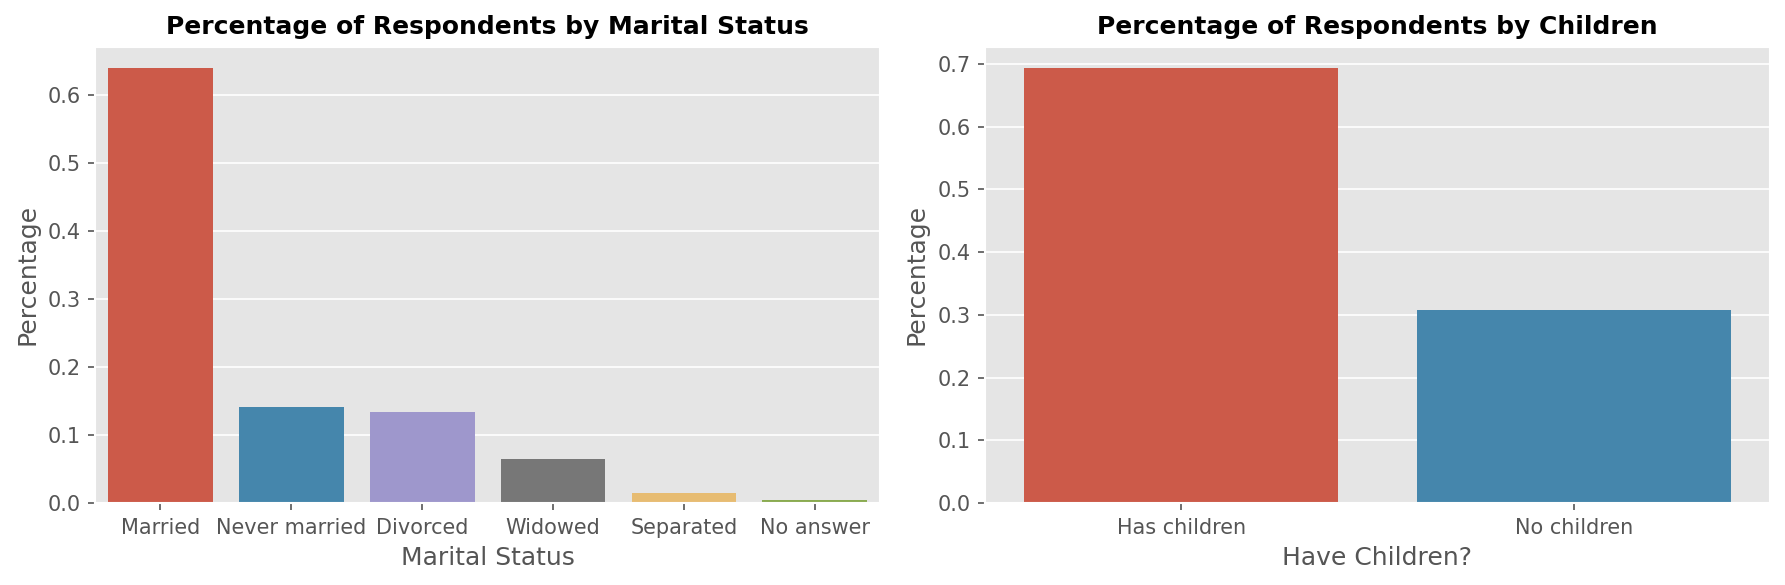

In [13]:
## plot a bar chart to visualize the information
plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
sns.barplot(data=marriage_df, x='Marital Status', y='Percentage').set_title(
    'Percentage of Respondents by Marital Status', weight='bold', size=12
)

## plot a pie chart to visualize
plt.subplot(1,2,2)
sns.barplot(data=children_df, x='Have Children?', y='Percentage').set_title(
    'Percentage of Respondents by Children', weight='bold', size=12
)

plt.tight_layout()

#### Demographics: Age & Sexual Orientation

In [14]:
## create a dataframe for age group
age_df = create_dataframe(survey_df, 'age3', 'Age Group')

## create a dataframe for sexual orientation
sex_df = create_dataframe(survey_df, 'q0026', 'Sexuality')

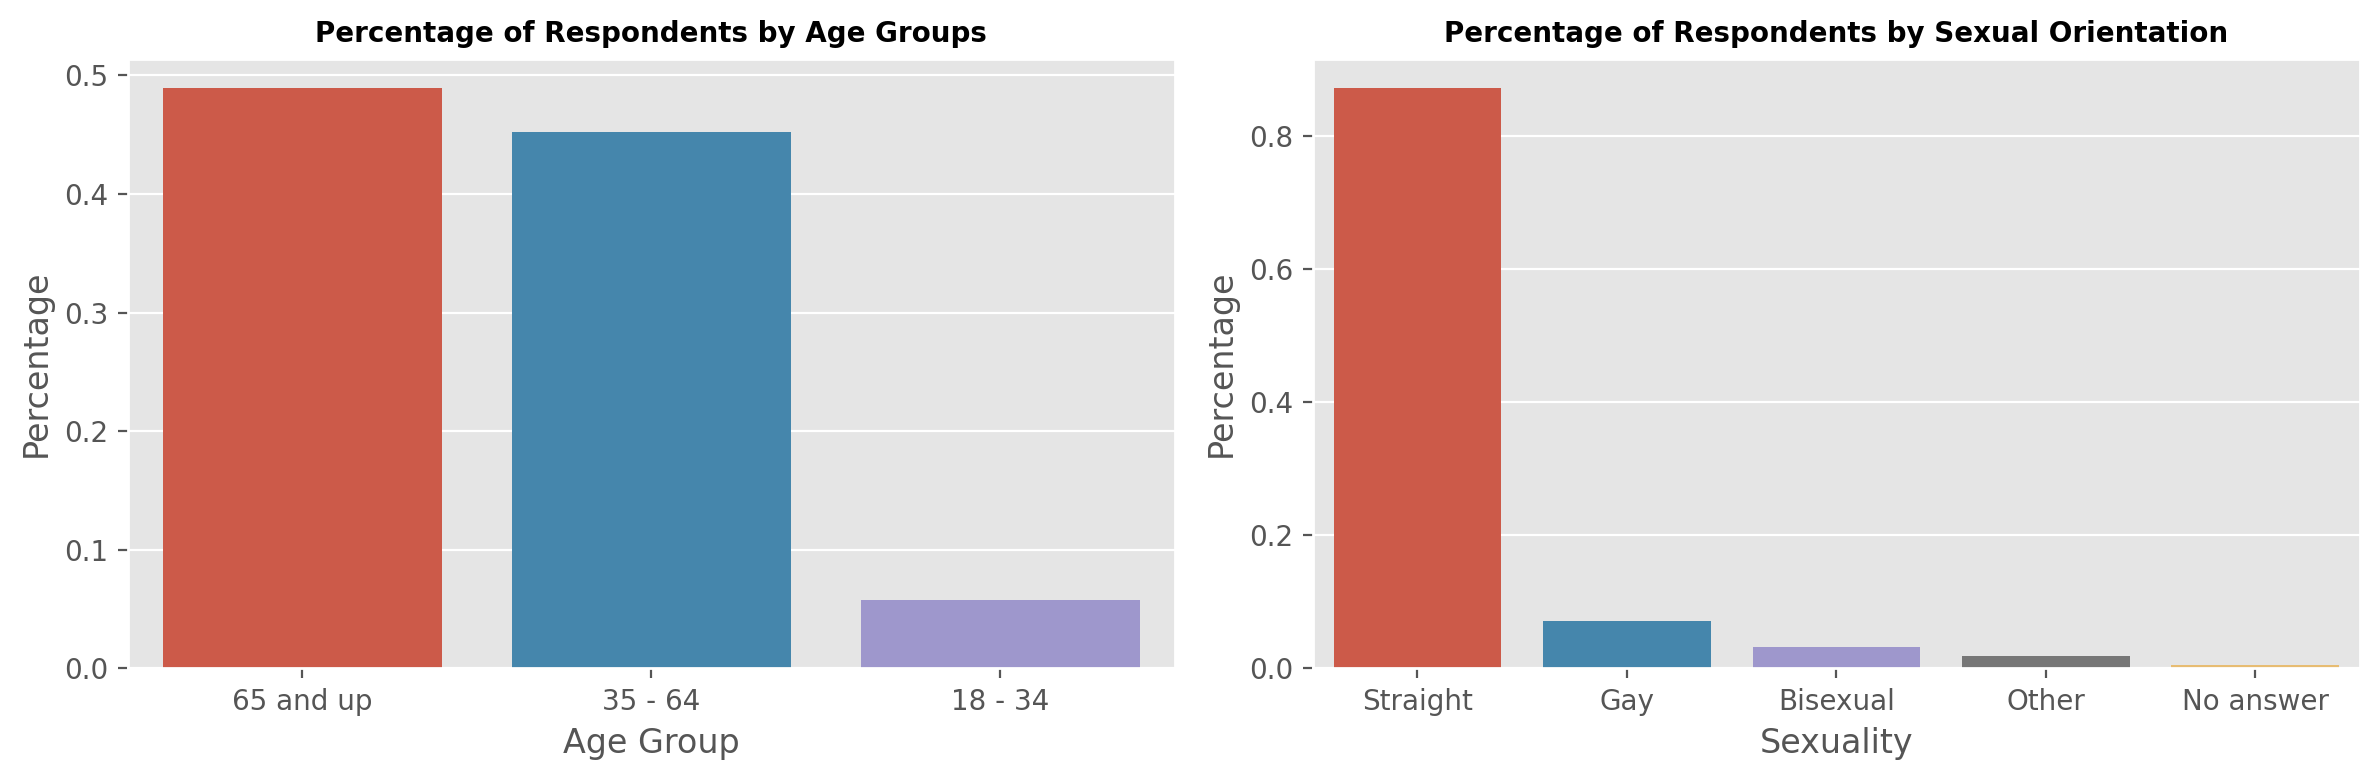

In [15]:
## plot a bar chart
plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,2,1)
sns.barplot(x='Age Group', y='Percentage', data=age_df).set_title(
    'Percentage of Respondents by Age Groups', weight='bold', size=10)

# plot a bar chart to visualize the information
plt.subplot(1,2,2)
sns.barplot(x='Sexuality', y='Percentage', data=sex_df).set_title(
    'Percentage of Respondents by Sexual Orientation', weight='bold', size=10)
plt.tight_layout()

#### Demographics: Employment Status & Education

In [16]:
## create a dataframe for occupations
job_df = create_dataframe(survey_df, 'q0009', 'Employment')

## create a dataframe for education
edu_df = create_dataframe(survey_df, 'q0029', 'Education')

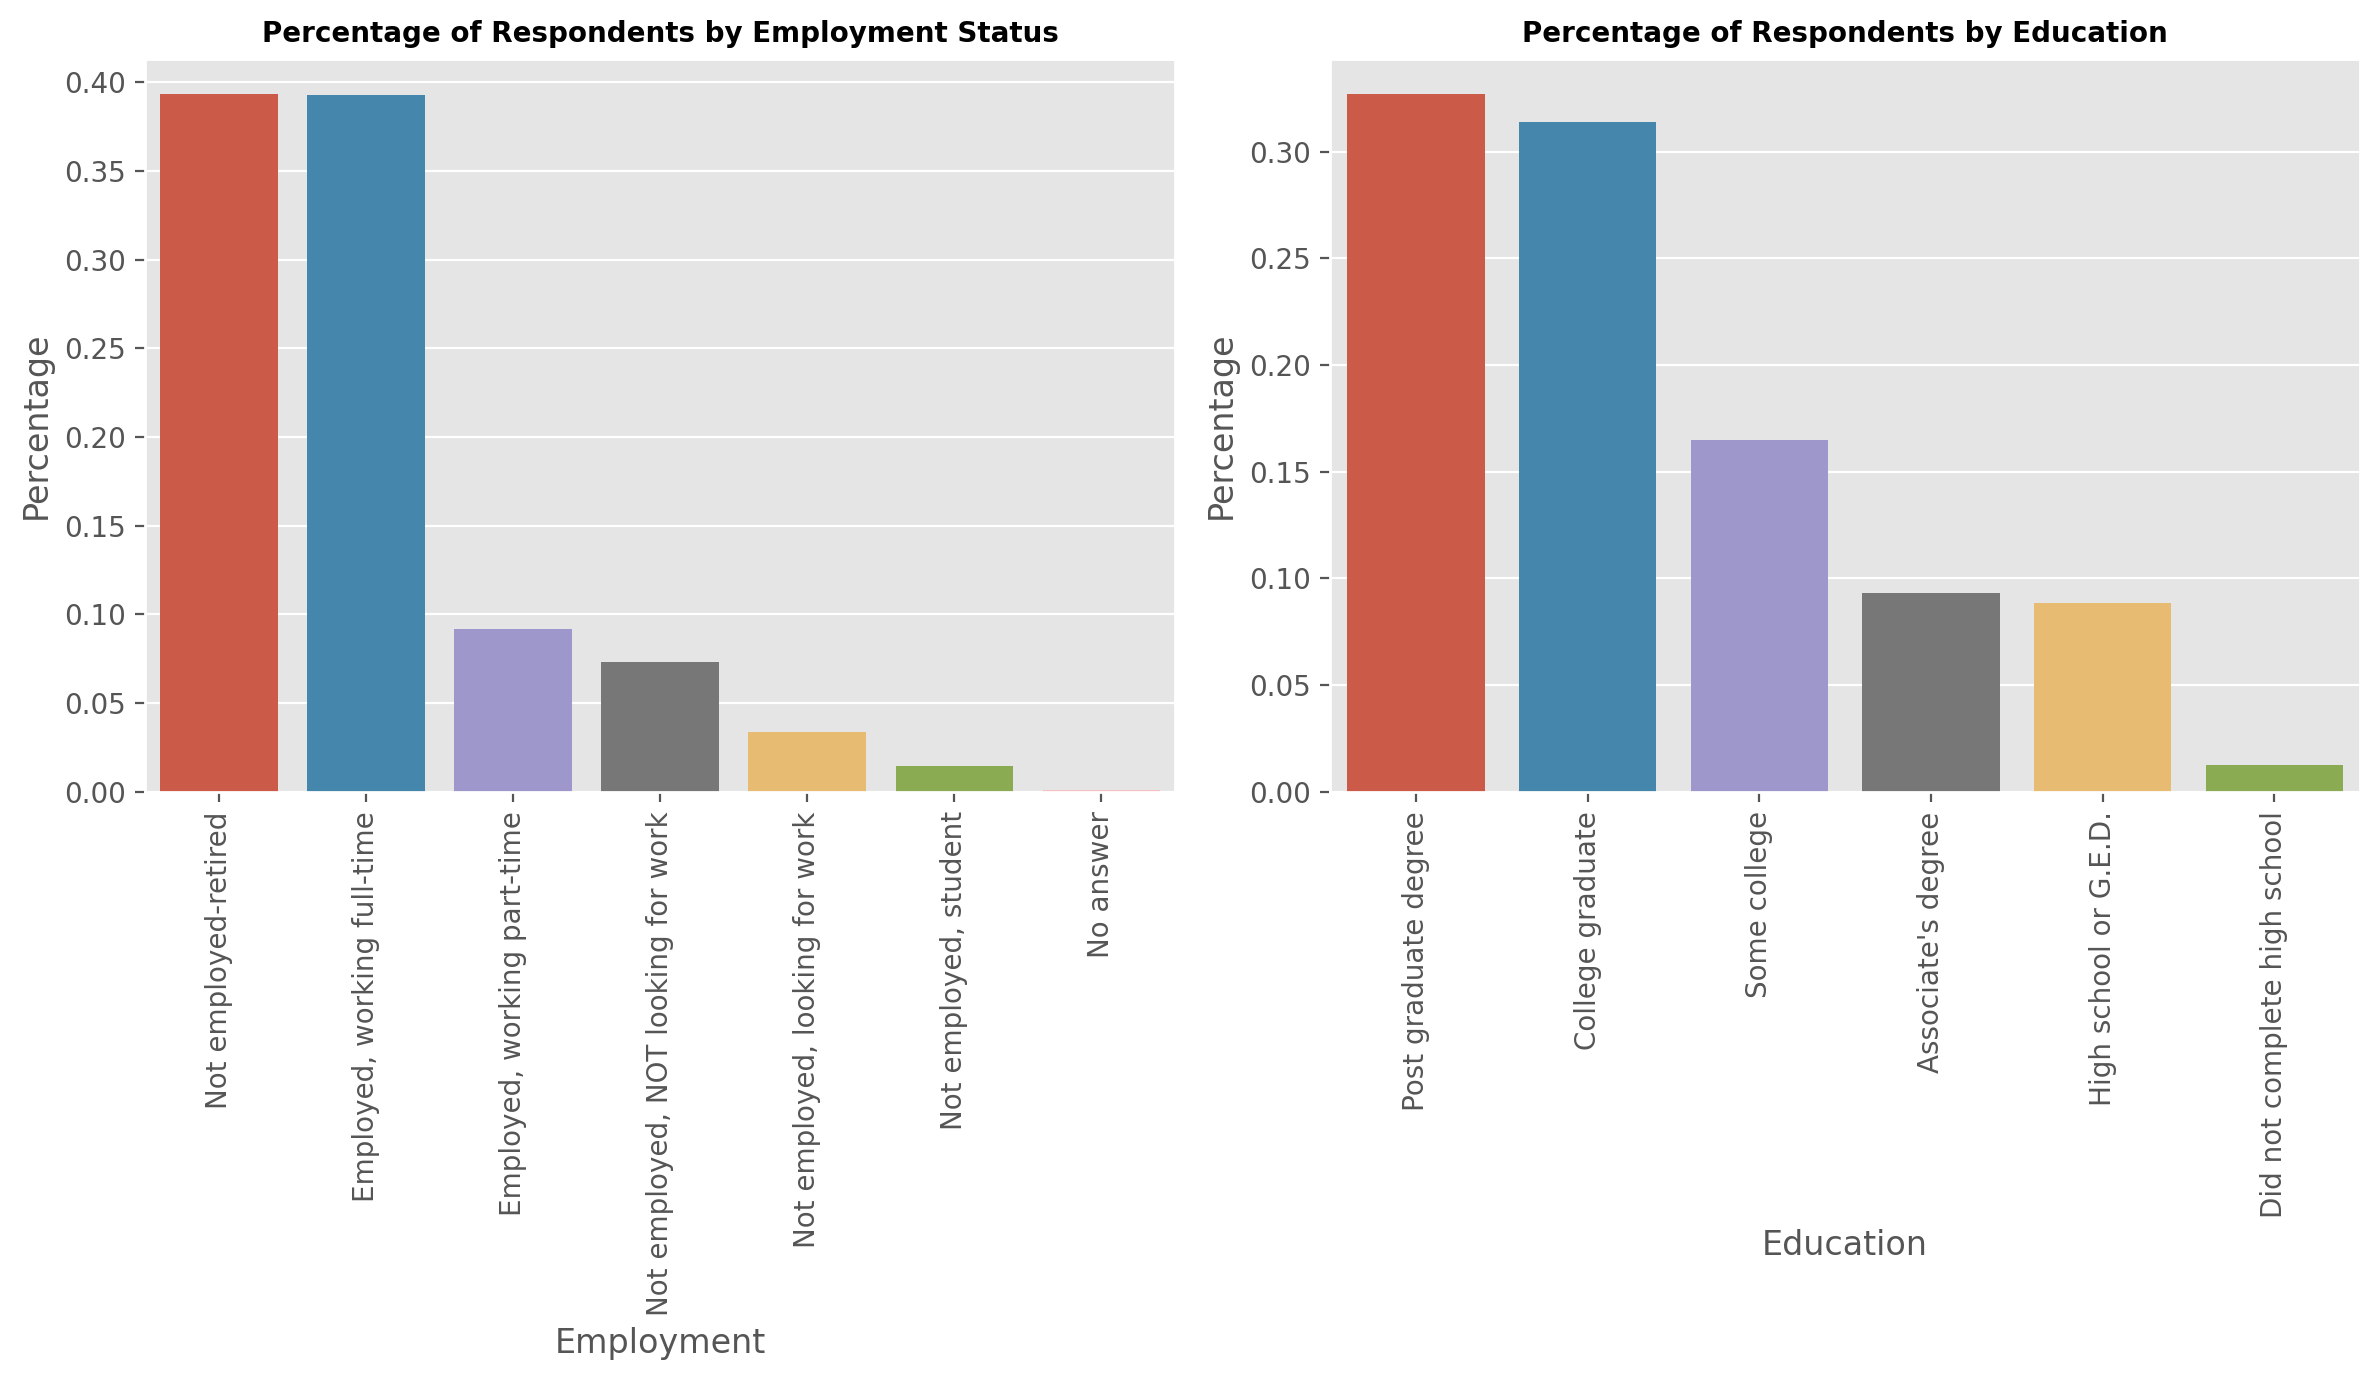

In [17]:
## plot a bar chart
plt.figure(figsize=(12,7), dpi=200)
plt.subplot(1,2,1)
sns.barplot(x='Employment', y='Percentage', data=job_df).set_title(
    'Percentage of Respondents by Employment Status', weight='bold', size=10)
plt.xticks(rotation=90)

## plot a bar chart
plt.subplot(1,2,2)
sns.barplot(x='Education', y='Percentage', data=edu_df).set_title(
    'Percentage of Respondents by Education', weight='bold', size=10)
plt.xticks(rotation=90)
plt.tight_layout()

------------

#### Ideas about masculinity 

In this section of the survey, the respondent are asked about what they think about masculinity in general. The questions include:
1. In general, how masculine or “manly” do you feel? (Question 1)
2. How important is it to you that others see you as masculine? (Question 2)
3. Where have you gotten your ideas about what it means to be a good man? (Question 4)
4. Do you think that society puts pressure on men in a way that is unhealthy or bad for them? (Question 5)


In [18]:
## create a dataframe for Q1 
q1_df = create_dataframe(survey_df, 'q0001', 'Answer')

## create a dataframe for Q2
q2_df = create_dataframe(survey_df, 'q0002', 'Answer')

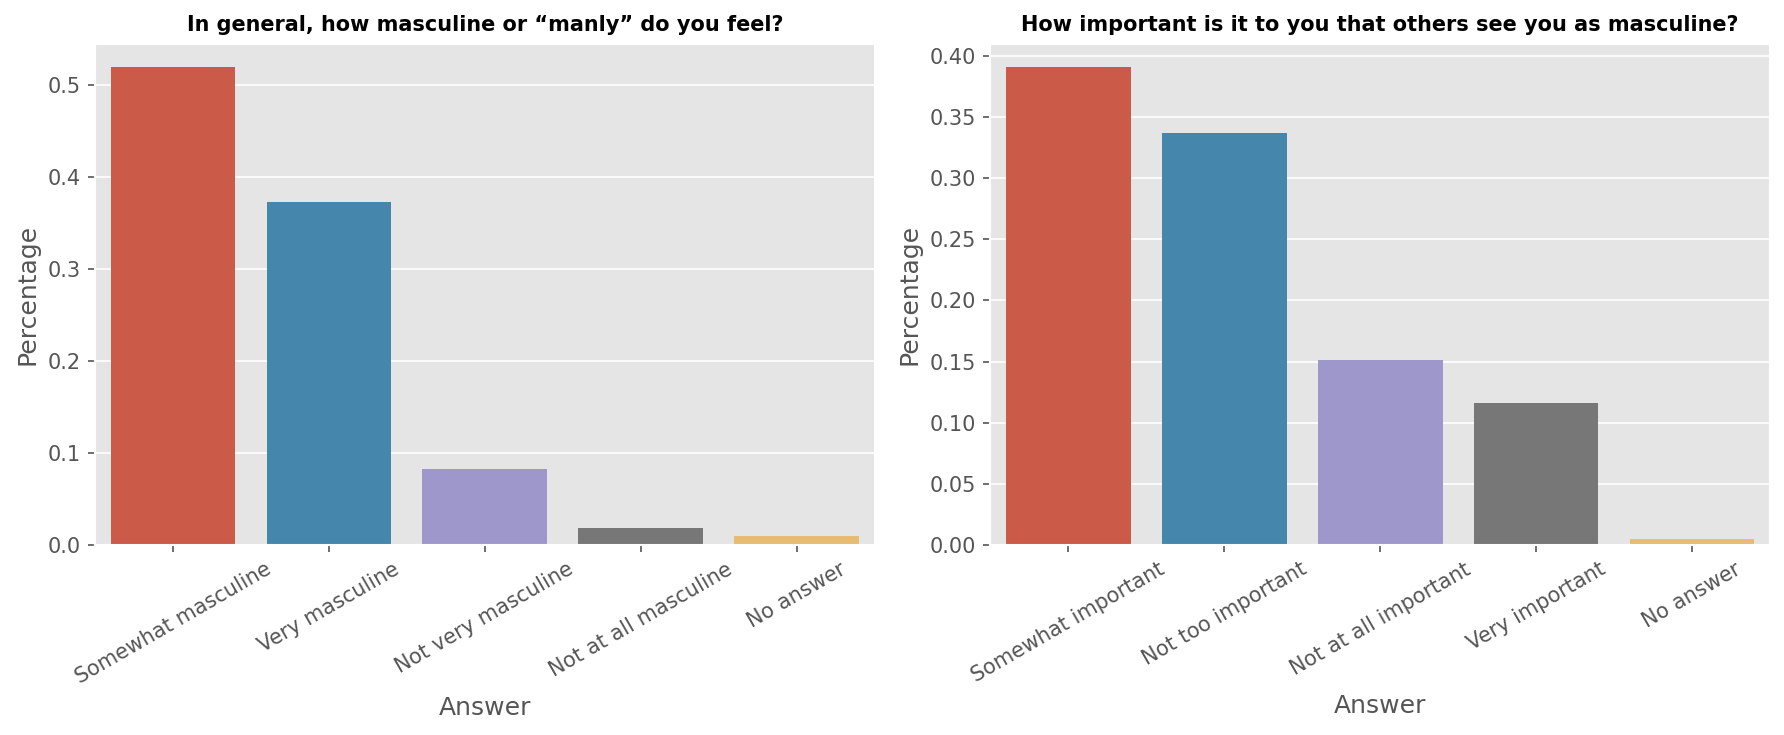

In [19]:
plt.figure(figsize=(12,5), dpi=150)

## plot a bar chart for Q1
plt.subplot(1,2,1)
sns.barplot(x='Answer', y='Percentage', data=q1_df).set_title(
    'In general, how masculine or “manly” do you feel?',
    weight='bold', size=10
)
plt.xticks(rotation=30)
## plot a bar chart for Q2
plt.subplot(1,2,2)
sns.barplot(x='Answer', y='Percentage', data=q2_df).set_title(
    'How important is it to you that others see you as masculine?',
    weight='bold', size=10
)
plt.xticks(rotation=30)
plt.tight_layout()

##### Summary
Most men, around 83%, when asked how they masculine they feel said they felt somewhat or very masculine and only a few of them said they were not at all masculine, less than 3%. On the other hand, only about 12% said it was very important that others see them that way and there is a large percentage of men, nearly 50%, said it was not too important or not at all important that others see them as masculine.

In general, there's no big difference among groups of men based on the sexuality when asked how masculine they feel or how import it is to them that others see them that way. However, among the men adopting other sexual identities, the percentage of those who said they felt not at all masculine is quite large, nearly 20% compared to men from other groups. There is also no difference between men from different age groups when asked the same questions. 

In [20]:
## group information by sexual orientation and question 1
q1_sex_df = group_two(survey_df, 'q0026', 'q0001', 'Sexuality', 'Answer')

## group information by age group and question 1
q1_age_df = group_two(survey_df, 'age3', 'q0001', 'Age Group', 'Answer')

## group information by sexual orientation and question 2
q2_sex_df = group_two(survey_df, 'q0026', 'q0002', 'Sexuality', 'Answer')

## group information by age group and question 2
q2_age_df = group_two(survey_df, 'age3', 'q0002', 'Age Group', 'Answer')

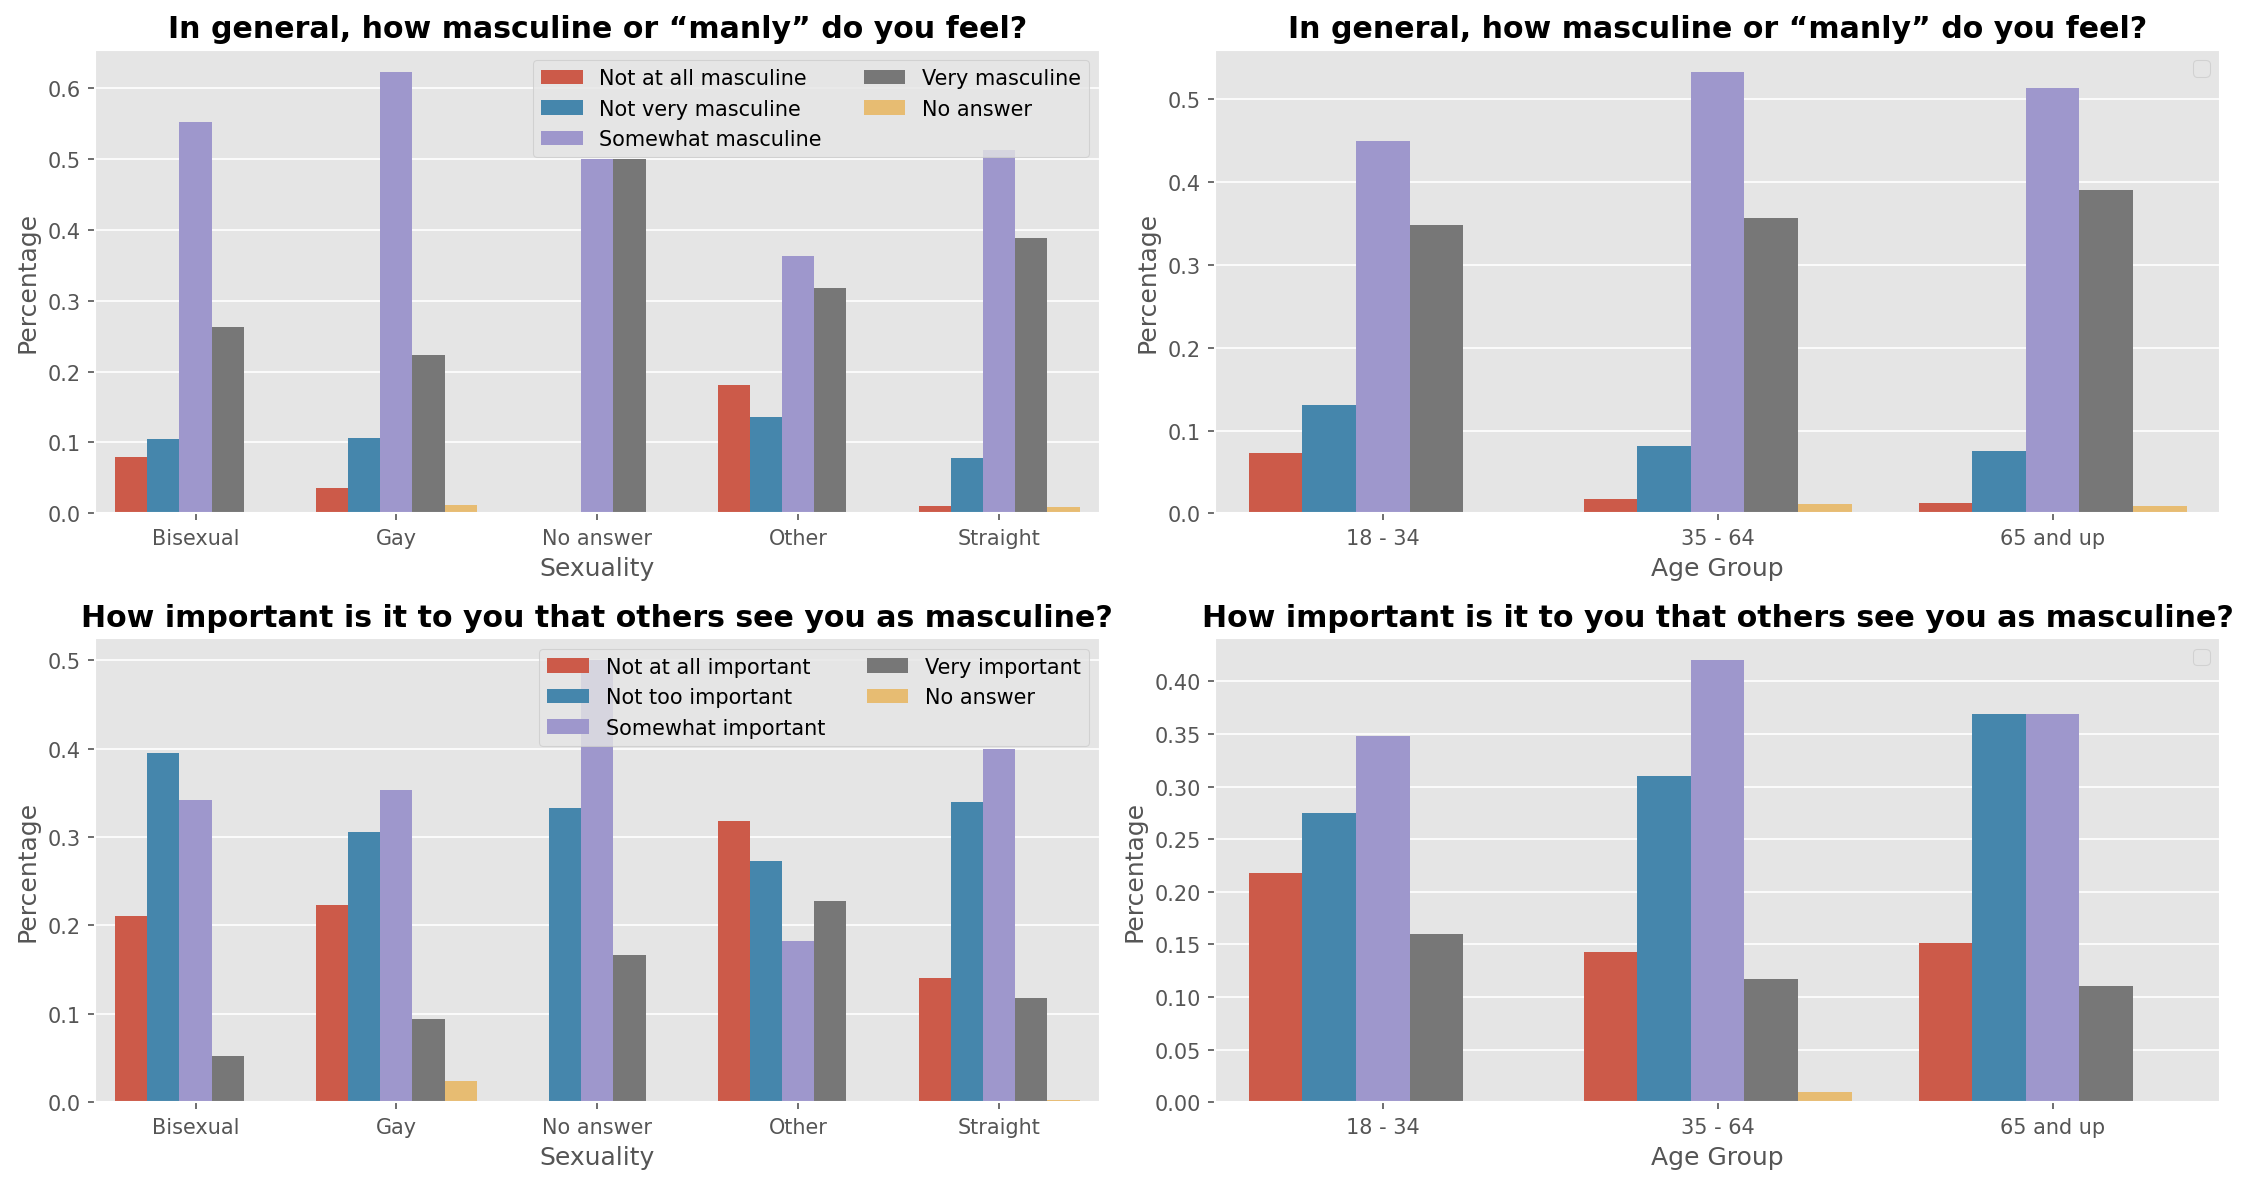

In [21]:
## plot bar plots
plt.figure(figsize=(15,8), dpi=150)

plt.subplot(2,2,1)
sns.barplot(x='Sexuality', y='Percentage', hue='Answer', data=q1_sex_df).set_title(
    'In general, how masculine or “manly” do you feel?', weight='bold')
plt.legend(ncol=2)

plt.subplot(2,2,2)  
sns.barplot(x='Age Group', y='Percentage', hue='Answer', data=q1_age_df).set_title(
    'In general, how masculine or “manly” do you feel?', weight='bold')
plt.legend('')

plt.subplot(2,2,3)
sns.barplot(x='Sexuality', y='Percentage', hue='Answer', data=q2_sex_df).set_title(
    'How important is it to you that others see you as masculine?', weight='bold')
plt.legend(ncol=2)

plt.subplot(2,2,4)    
sns.barplot(x='Age Group', y='Percentage', hue='Answer', data=q2_age_df).set_title(
    'How important is it to you that others see you as masculine?', weight='bold')
plt.legend('')

plt.tight_layout()

In [22]:
## create a dataframe for question 4
q4_df = merge_group_columns1(survey_df, ['q0004_0001', 'q0004_0002', 'q0004_0003', 'q0004_0004', 'q0004_0005', 'q0004_0006'])

## create a dataframe for question 4 (by age groups)
q4_age_df = merge_group_columns2(
    survey_df, 'Age Group', 
    ['age3', 'q0004_0001', 'q0004_0002', 'q0004_0003', 'q0004_0004', 'q0004_0005', 'q0004_0006']
)

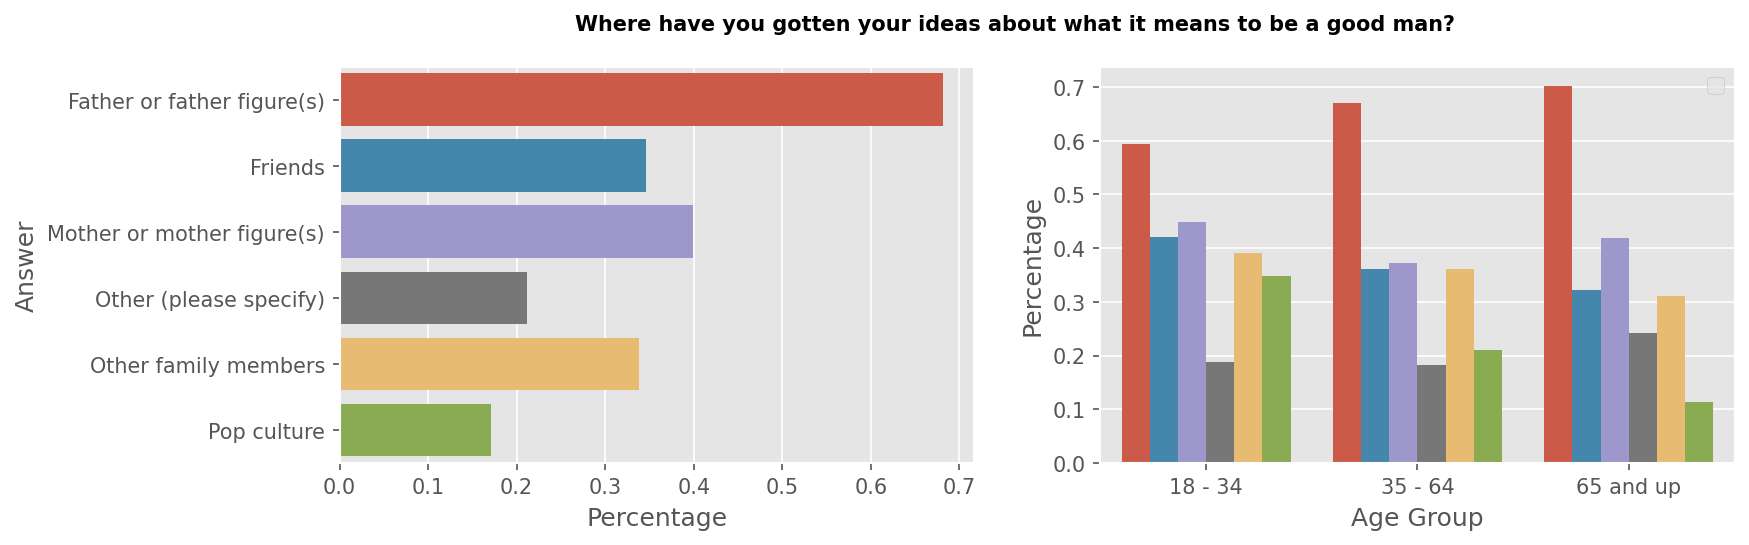

In [23]:
plt.figure(figsize=(12,3.5), dpi=150)

## plot a bar chart for Q4
plt.subplot(1,2,1)
sns.barplot(y='Answer', x='Percentage', data=q4_df)

## plot a bar chart for Q4 (by age groups)
plt.subplot(1,2,2)
sns.barplot(x='Age Group', y='Percentage', hue='Answer', data=q4_age_df)
plt.suptitle(
    'Where have you gotten your ideas about what it means to be a good man?',
    weight='bold', size=10
)
plt.legend('')

##### Summary
Most men, more than 68%, said that their father or a father figure was a source of their ideas about what it means to be a good man. At around 39%, mother or a mother figure came in second. Moreover, the chart shows that there are more men in older groups who mentioned father or a father figure as their source of inspiration. This could be a generational difference. Another difference between generations is "Pop Culture". Nearly 35% of younger men aged 18-34 said pop culture was their source of ideas, while only 20% of men 35 to 64 and 11% of men 65 and over said the same. 

The respondents were asked if they thought that society puts pressure on men in a way that is unhealthy or bad; most said yes (nearly 60%).

In [24]:
## group data by question 5
q5_df = create_dataframe(survey_df, 'q0005', 'Answer')

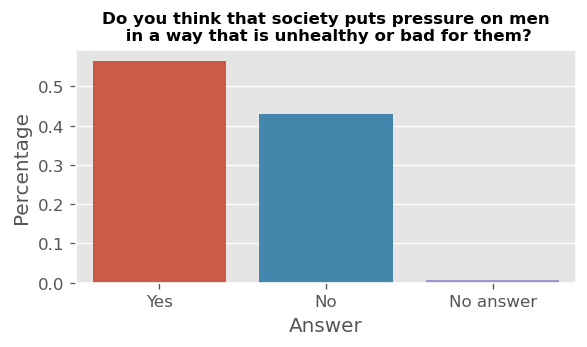

In [25]:
plt.figure(figsize=(5,3), dpi=120)

## plot a bar chart for Q5
sns.barplot(x='Answer', y='Percentage', data=q5_df).set_title(
    'Do you think that society puts pressure on men\n in a way that is unhealthy or bad for them?',
    weight='bold', size=10
)
plt.tight_layout()

------------

#### General aspects of life

In [26]:
## create a dataframe for question 8
q8_df = merge_group_columns1(survey_df, ['q0008_0001', 'q0008_0002', 'q0008_0003', 'q0008_0004', 'q0008_0005', 'q0008_0006', 
     'q0008_0007', 'q0008_0008', 'q0008_0009', 'q0008_0010', 'q0008_0011', 'q0008_0012'])

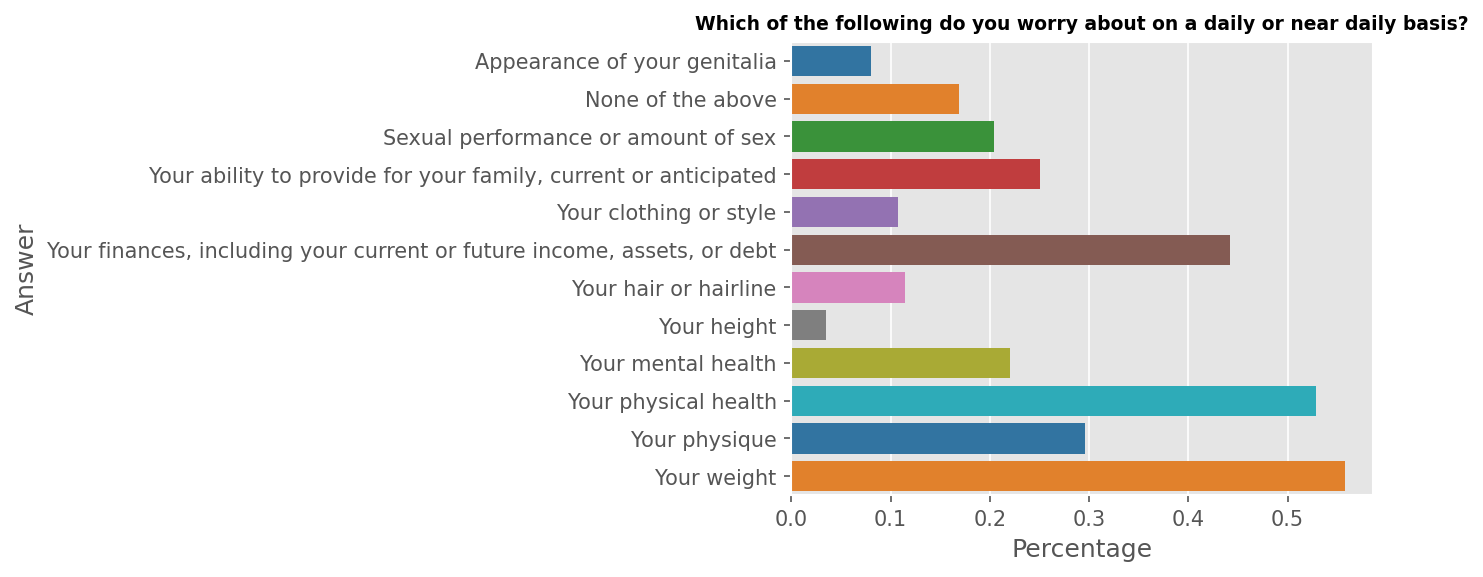

In [27]:
## plot a bar chart for Q8
plt.figure(figsize=(5,4), dpi=150)
ax = sns.barplot(y='Answer', x='Percentage', palette='tab10', data=q8_df).set_title(
    'Which of the following do you worry about on a daily or near daily basis?', weight='bold', size=9)

##### Summary
In general, the respondents' three biggest concerns include their weight (more than 50%), their physical health (52%) and their finances (43%). The interesting finding is that only 9 percent of the respondents said they worried about the apperance of their genitality and less than 5 percent said they were concerned about their height. 

Comparing age groups, older men seem to care more about their physical helath. More than 55% of men 65 and over said they worried about their physical health on a daily basis while only 40% of men in the youngest group said so. On the other hand, it seems that the older they get, the less they worry about their mental health. While more than 45% of men 18 to 34 said mental health was one of their concerns, only 25% of men 35 to 64 and less than 20% of men 65 and over said so. The same goes for finances and the ability to provide for their family. 

In [28]:
## create a dataframe for question 8 (for different age groups)
q8_age_df = merge_group_columns2(
    survey_df, 'Age Group', 
    ['age3', 'q0008_0001', 'q0008_0002', 'q0008_0003', 'q0008_0004', 'q0008_0005', 'q0008_0006', 
     'q0008_0007', 'q0008_0008', 'q0008_0009', 'q0008_0010', 'q0008_0011', 'q0008_0012']
)

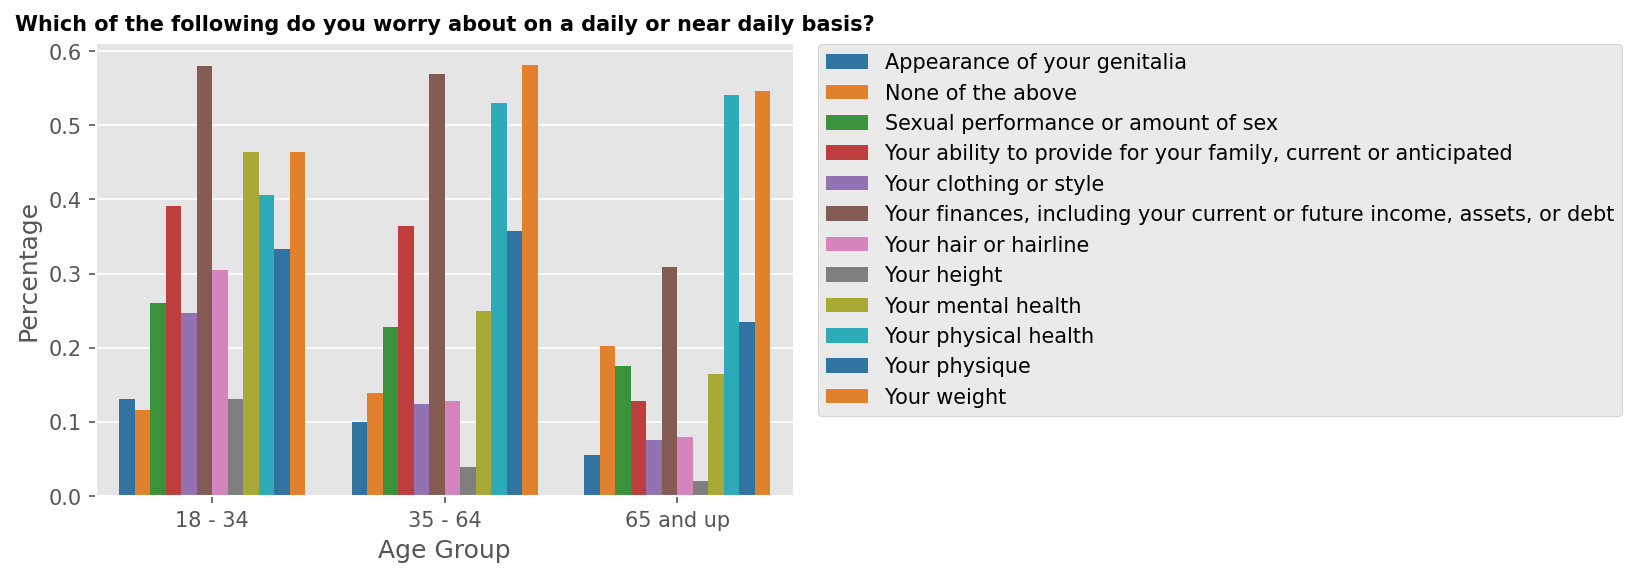

In [29]:
## plot a bar chart for Q8 (for different age groups)
plt.figure(figsize=(6,4), dpi=150)
ax = sns.barplot(x='Age Group', y='Percentage', hue='Answer', palette='tab10', data=q8_age_df).set_title(
    'Which of the following do you worry about on a daily or near daily basis?', weight='bold', size=10)
plt.legend(bbox_to_anchor=(1.02, 1.02))

------------

#### Experiences at work

The employed respondents (accounting for nearly 50%) are asked four questions about their experiences at work including: 
1. In which of the following ways would you say it’s an advantage to be a man at your work right now? (Question 10)
2. In which of the following ways would you say it’s a disadvantage to be a man at your work right now? (Question 11)
3. Have you seen or heard of a sexual harassment incident at your work? If so, how did you respond? (Question 12)
4. How much have you heard about the #MeToo movement? (Question 14)

In [30]:
## create a dataframe containg only employed respondents
employment_df = survey_df[(survey_df.q0009 == 'Employed, working full-time') | (survey_df.q0009 == 'Employed, working part-time')]

In [31]:
## create a dataframe for question 10
q10_df = merge_group_columns1(
    employment_df,
    ['q0010_0001', 'q0010_0002', 'q0010_0003', 'q0010_0004', 'q0010_0005', 'q0010_0006', 'q0010_0007', 'q0010_0008']
)

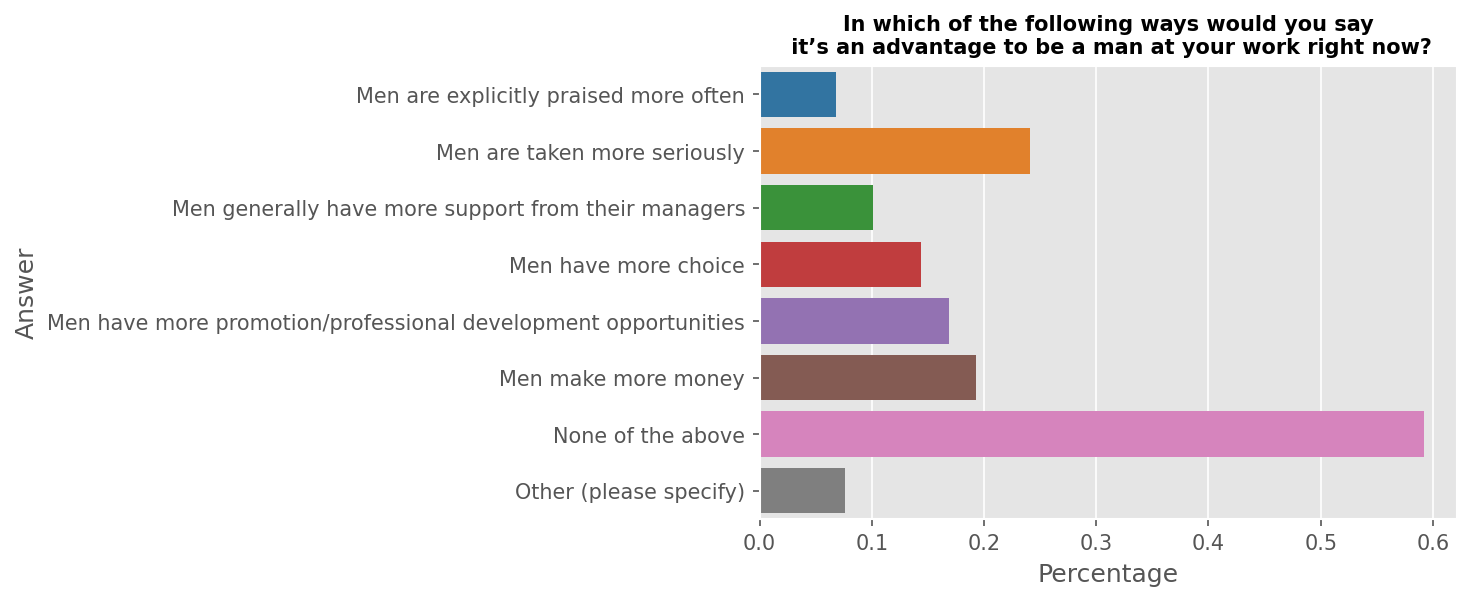

In [32]:
## plot a bar chart for Q10
plt.figure(figsize=(6,4), dpi=150)
ax = sns.barplot(y='Answer', x='Percentage', palette='tab10', data=q10_df).set_title(
    'In which of the following ways would you say\n it’s an advantage to be a man at your work right now?', weight='bold', size=10)

##### Summary
When asked about advantages of being a man at work, most respondents said there were no advantages to be had. However, there is still nearly 25 percent of the employed men said that men are taken more seriously in the workplace and around 20 percent shared that men make more money.

In [33]:
## create a dataframe for question 11
q11_df = merge_group_columns1(employment_df, ['q0011_0001', 'q0011_0002', 'q0011_0003', 'q0011_0004', 'q0011_0005'])

## create a dataframe for question 11 (by age groups)
q11_age_df = merge_group_columns2(
    employment_df, 'Age Group',
    ['age3', 'q0011_0001', 'q0011_0002', 'q0011_0003', 'q0011_0004', 'q0011_0005']
)

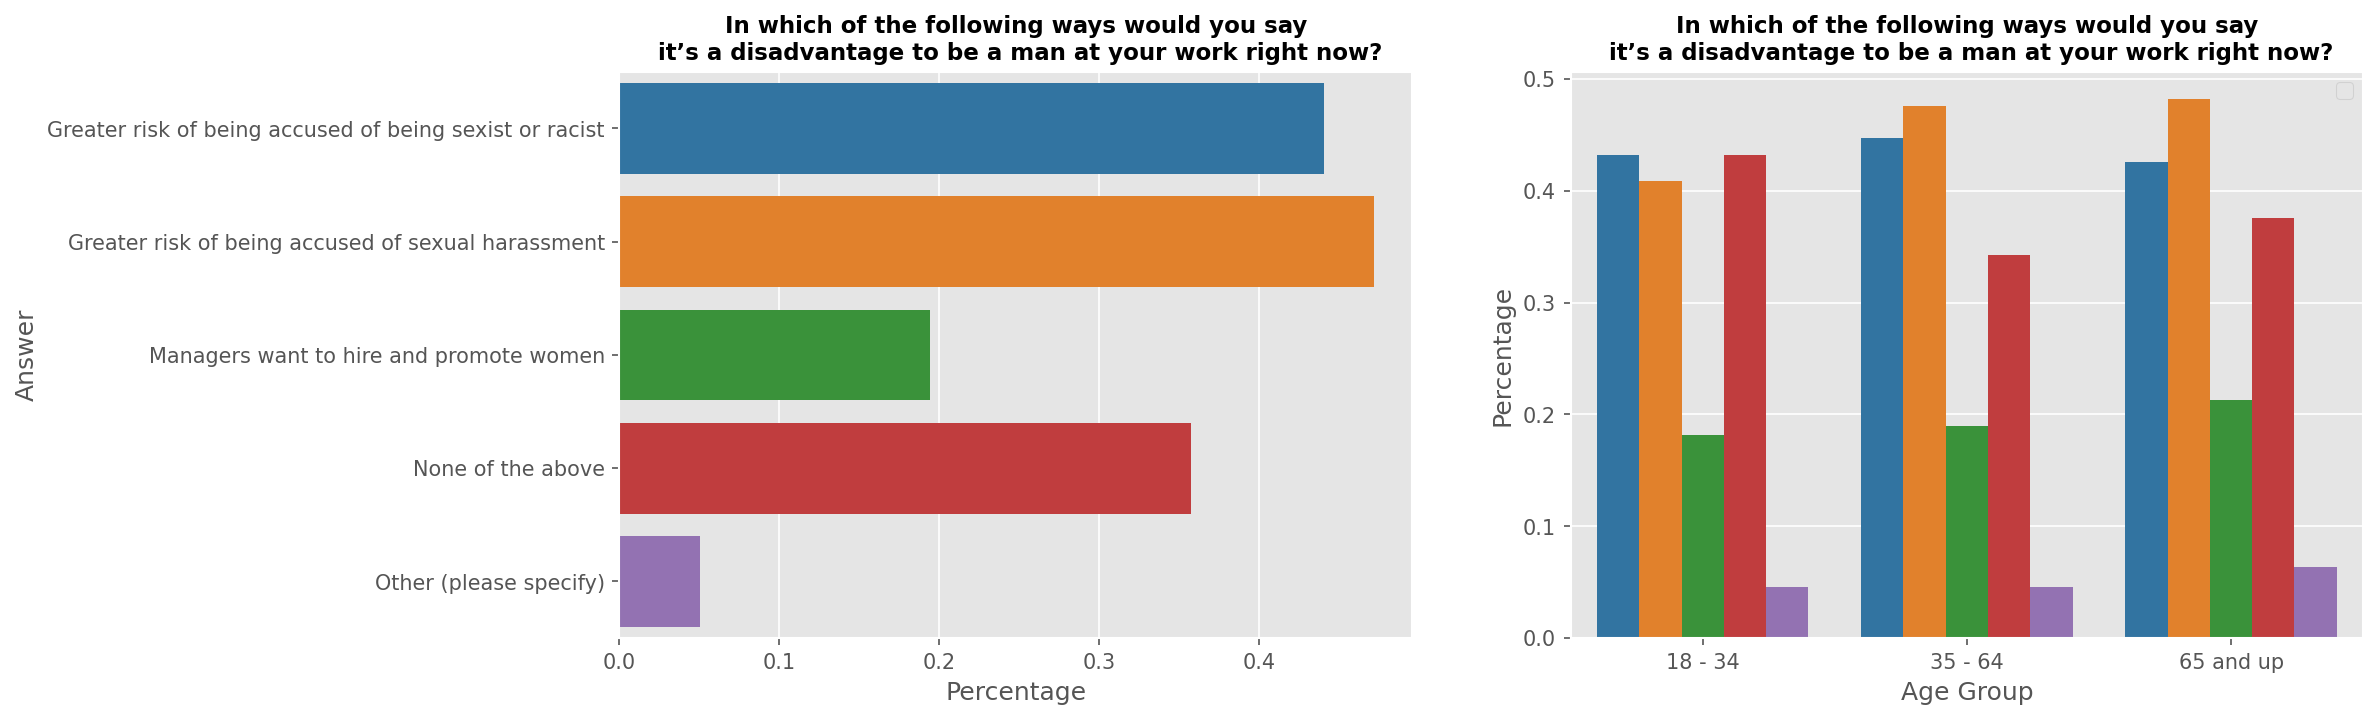

In [34]:
## plot a bar chart for Q11
plt.figure(figsize=(15,5), dpi=150)
plt.subplot(1,2,1)
sns.barplot(y='Answer', x='Percentage', palette='tab10', data=q11_df).set_title(
    'In which of the following ways would you say\n it’s a disadvantage to be a man at your work right now?', weight='bold', size=11)

## plot a bar chart for Q11 (by age groups)
plt.subplot(1,2,2)
sns.barplot(x='Age Group', y='Percentage', hue='Answer', palette='tab10', data=q11_age_df).set_title(
    'In which of the following ways would you say\n it’s a disadvantage to be a man at your work right now?', weight='bold', size=11)
plt.legend('')

##### Summary
Nearly half of the respondents said men are at a greater risk of being accused of sexual harassment or of being sexist or racist and less than 20% agreed that managers wanting to hire and promote women was one of the disadvantages. Also, there seems to be no big difference between age groups.  

Despite saying that men are at a greater risk of being accused of sexual harassment at work, nearly three-quarters said they had never witnessed any incident of such kind. It is also surprising that more 15 percent of the employed respondents said they had never heard of the #MeToo movement. 

In [35]:
## create a dataframe for Q12 
q12_df = merge_group_columns1(
    employment_df,
    ['q0012_0001', 'q0012_0002', 'q0012_0003', 'q0012_0004', 'q0012_0005', 'q0012_0006', 'q0012_0007']
)

## create a dataframe for Q14
q14_df = create_dataframe(employment_df, 'q0014', 'Answer')

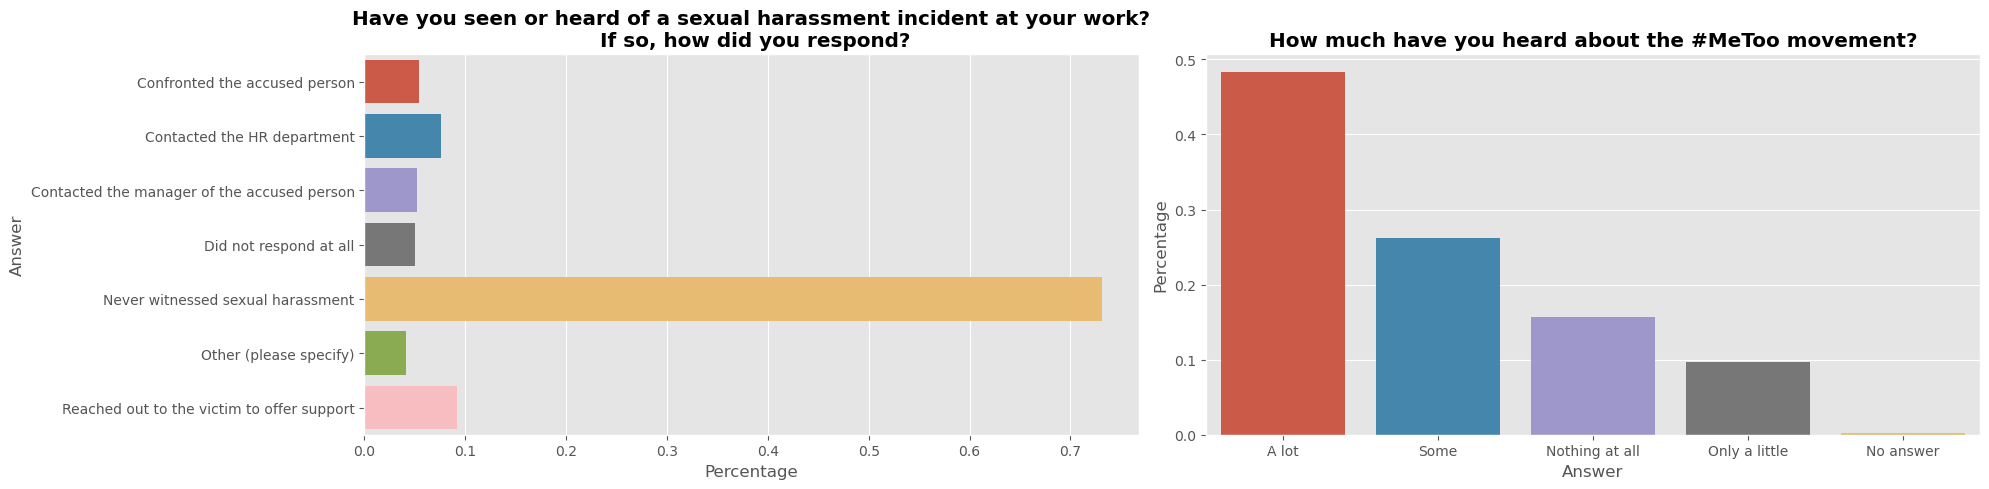

In [36]:
# plot a bar chart for Q12
plt.figure(figsize=(20,5), dpi=100)

plt.subplot(1,2,1)
ax = sns.barplot(y='Answer', x='Percentage', data=q12_df)
plt.title('Have you seen or heard of a sexual harassment incident at your work?\n If so, how did you respond?', weight='bold')

## plot a bar chart for Q14
plt.subplot(1,2,2)
sns.barplot(x='Answer', y='Percentage', data=q14_df).set_title(
    'How much have you heard about the #MeToo movement?', weight='bold'
)
plt.tight_layout()

#### Relationship

In this section of the survey, the respondents are asked:
1. Do you typically feel as though you’re expected to make the first move in romantic relationships? (question 17)
2. How often do you try to be the one who pays when on a date? (question 18)
3. [Among “Always”& “Often”] Which of the following are reasons why you try to pay when on a date? (question 19)
. Have you changed your behavior in romantic relationships in the wake of #MeToo movement? (question 22)

In [37]:
## create a dataframe for Q17
q17_df = create_dataframe(survey_df, 'q0017', 'Answer')

## create a dataframe for Q18
q18_df = group_two(survey_df, 'age3', 'q0018', 'Age Group', 'Answer')

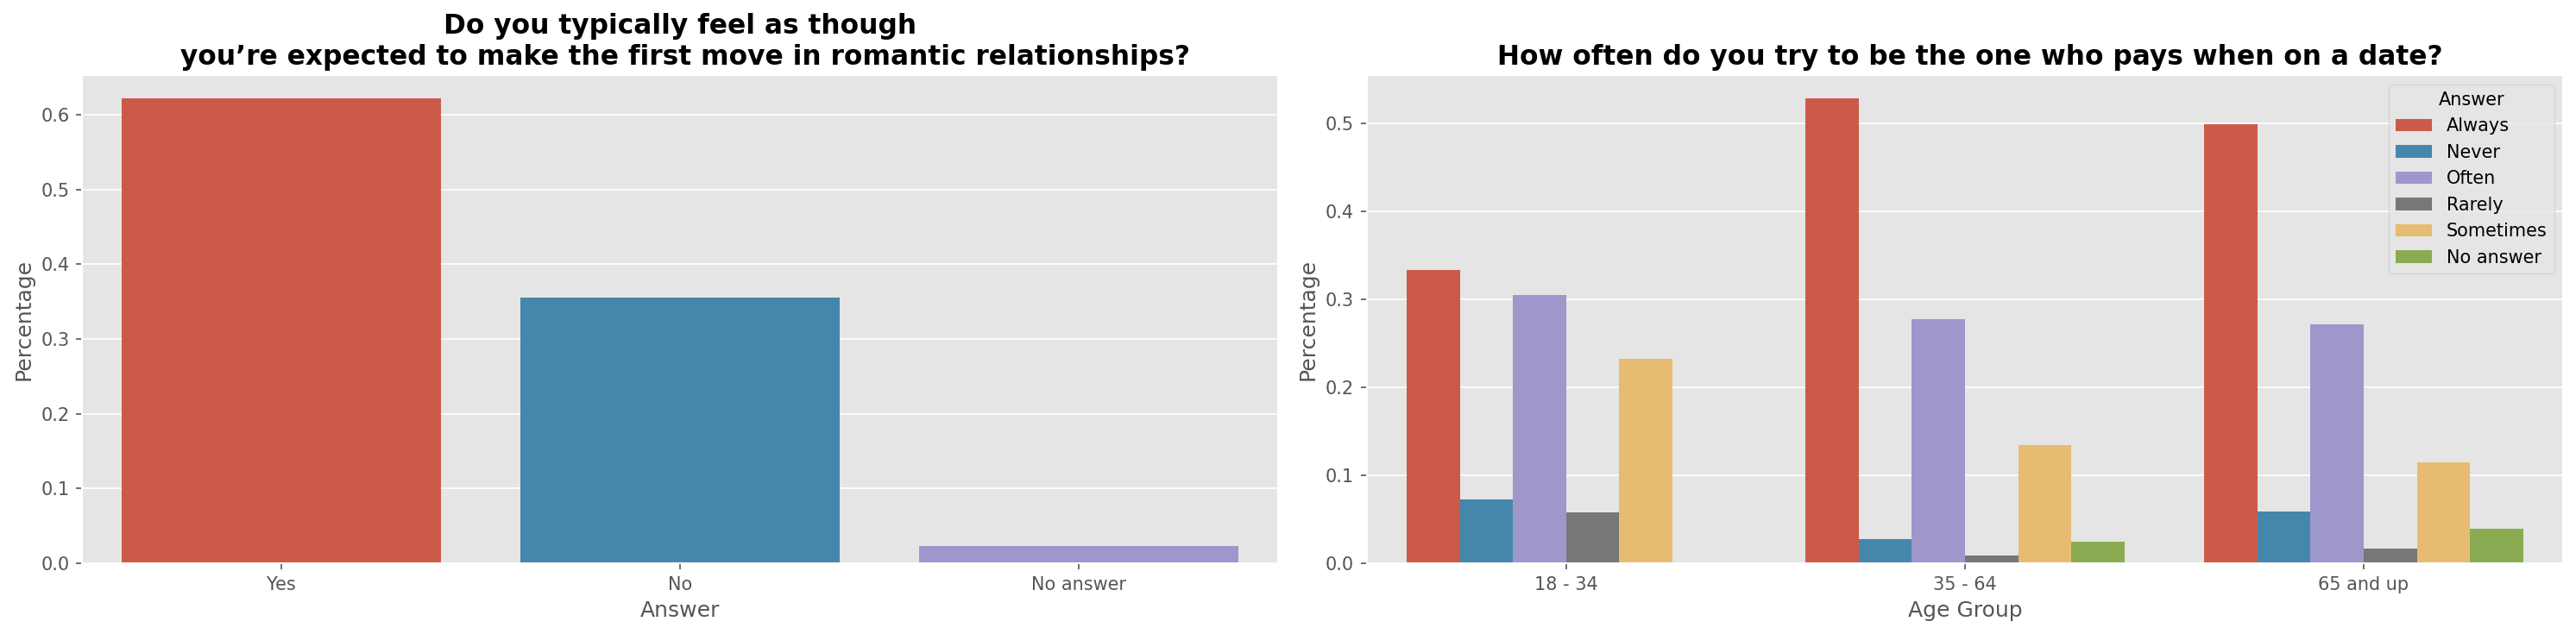

In [38]:
plt.figure(figsize=(20, 5), dpi=150)

## plot a bar chart for question 17
plt.subplot(1,2,1)
sns.barplot(x='Answer', y='Percentage', data=q17_df).set_title(
    'Do you typically feel as though\n you’re expected to make the first move in romantic relationships?',
    weight='bold', size=15
)

## plot a bar chart for question 18
plt.subplot(1,2,2)
sns.barplot(x='Age Group', y='Percentage', hue='Answer', data=q18_df).set_title(
    ' How often do you try to be the one who pays when on a date?',
    weight='bold', size=15
)
plt.tight_layout()

##### Summary
Most reported that they were expected to be the first to take action in romantic relations; more than 60 percent of the respondents said yes to the question, and around 50% said they always tried to pay when on dates. Younger men differ from their older counterparts when it comes to paying for a date; only 32% said they always tried while more than 50% of men who are 35 and over said the same. 

Among those who said they always or often tried to pay on dates, nearly 70 percent said the reason was because it is the right thing to do, and around 55% said they felt obligated to pay since they asked others out. On the other hand, only 5 percent admitted that it was because they wanted to see if their dates would offer to split the bill. 

When aksed if they had changed their dating behaviors in the wake of the #MeToo movement, approximately 88% said hadn't. 

In [39]:
## create a dataframe containg only the respondents answering `Always` or `Often` for question 18
always_often_df = survey_df[(survey_df.q0018 == 'Always') | (survey_df.q0018 == 'Often')]

## create a dataframe for Q19 
q19_df = merge_group_columns1(
    always_often_df,
    ['q0019_0001', 'q0019_0002', 'q0019_0003', 'q0019_0004', 'q0019_0005', 'q0019_0006', 'q0019_0007'])

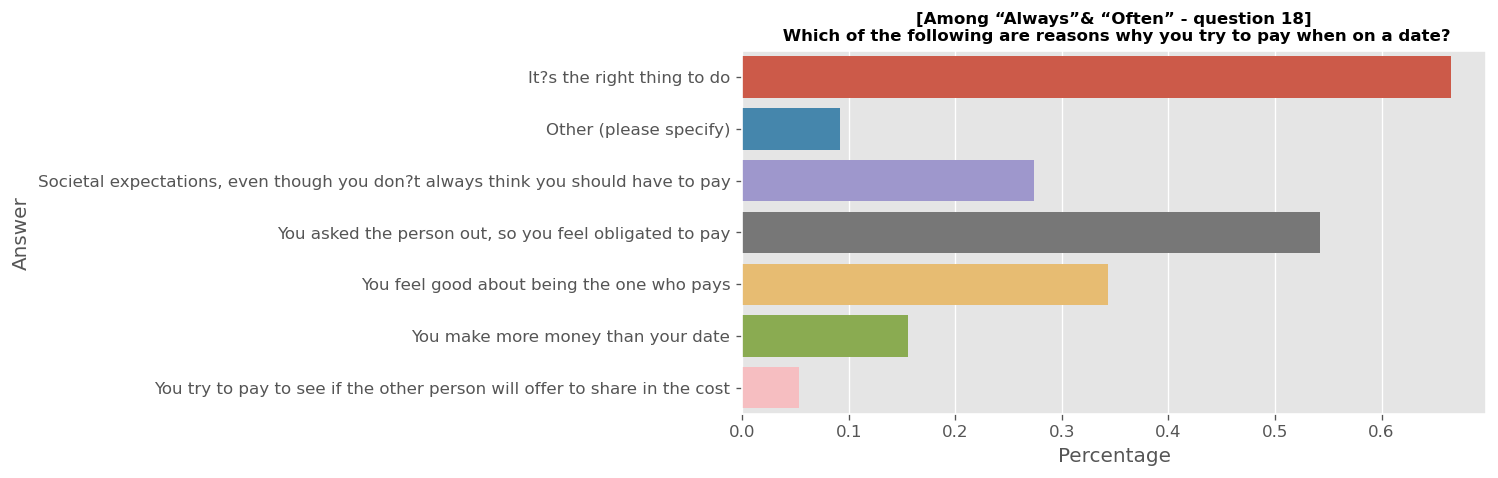

In [40]:
## plot a bar chart for question 19
plt.figure(figsize=(8,4), dpi=120)
ax = sns.barplot(y='Answer', x='Percentage', data=q19_df)
plt.title('[Among “Always”& “Often” - question 18]\n Which of the following are reasons why you try to pay when on a date?', weight='bold', size=10)
plt.show()

In [41]:
## create a dataframe for Q22
q22_df = create_dataframe(survey_df, 'q0022', 'Answer')

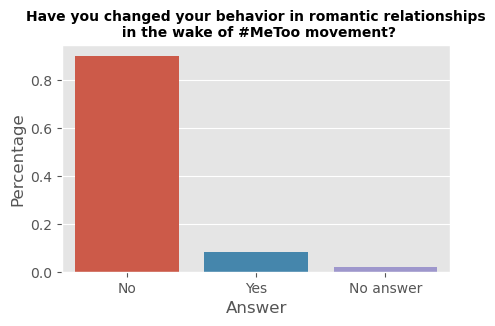

In [42]:
## plot a bar chart for question 22
plt.figure(figsize=(5,3), dpi=100)
sns.barplot(x='Answer', y='Percentage', data=q22_df).set_title(
    'Have you changed your behavior in romantic relationships\n in the wake of #MeToo movement?',
    weight='bold', size=10
)
plt.show()

### Part 3: KMeans Classification Model

In [43]:
## drop columns with NaN values and create a new dataframe for model building
model_df = survey_df.drop(cols_to_drop, axis=1)

In [44]:
## replace 'No answer' with np.nan and drop those rows
model_df = model_df.replace('No answer', np.nan)
model_df.dropna(inplace=True)

#### Mapping and Label Encoding the Values

##### Ordinal variables

In [45]:
## Encode ordinal variables
## Question 1
model_df['q0001'] = pd.Categorical(
    model_df['q0001'],
    categories=['Not at all masculine', 'Not very masculine', 'Somewhat masculine', 'Very masculine'],
    ordered=True
)
model_df['q0001_code'] = model_df['q0001'].cat.codes

## Question 2
model_df['q0002'] = pd.Categorical(
    model_df['q0002'],
    categories=['Not at all important', 'Not too important', 'Somewhat important', 'Very important'],
    ordered=True
)
model_df['q0002_code'] = model_df['q0002'].cat.codes

## Question 18
model_df['q0018'] = pd.Categorical(
    model_df['q0018'],
    categories=['Never', 'Rarely', 'Sometimes', 'Often', 'Always'],
    ordered=True
)
model_df['q0018_code'] = model_df['q0002'].cat.codes

## Question 7
q7_cols = survey_df.filter(regex='q0007_.').columns.tolist()
for column in q7_cols:
    model_df[column] = pd.Categorical(
        model_df[column],
        categories=['Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'],
        ordered=True
    )
    model_df[f'{column}_code'] = model_df[column].cat.codes

##### Binary variables

In [46]:
## build a function to encode binary variables
def encode_binary(regex):
    col_df = model_df.filter(regex=regex).columns.tolist()
    for column in col_df:
        model_df[f'{column}_code'] = model_df[column].apply(
            lambda x: 0 if x == 'Not selected' else (0 if x == 'No' else (0 if x == 'No children' else 1)))

In [47]:
## encode binary variables
regex_cols = ['q0004_.', 'q0008_.', 'q0020_.', 'q0021_.', 'q0005', 'q0017', 'q0022', 'kids']
for column in regex_cols:
    encode_binary(column)

##### Nomial variables

In [63]:
## import essential libraries
from sklearn.preprocessing import LabelEncoder

In [64]:
## create a LabelEncoder object
encoder = LabelEncoder()

## encode nomial variables
nomial_cols = model_df.select_dtypes('object').columns.tolist()
for column in nomial_cols:
    model_df[f'{column}_code'] = encoder.fit_transform(model_df[column])

#### KMeans Classification Model

In [65]:
## import KMeans 
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Inertias of KMeans models by K (number of clusters)')

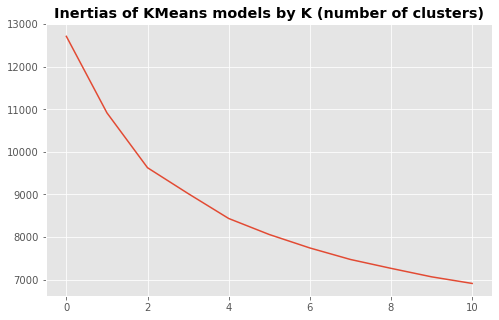

In [66]:
## columns for model
train_cols = model_df.filter(regex='q0007\_\d{4}_code').columns.tolist()
## check for the best K 
inertias = []
for k in range(1,12):
    clf = KMeans(n_clusters=k)
    clf.fit(model_df[train_cols])
    inertias.append(clf.inertia_)

plt.figure(figsize=(8,5))
plt.plot(inertias)
plt.title('Inertias of KMeans models by K (number of clusters)', weight='bold')

In [70]:
## Fit a KMeans model with n_clusters = 3
clf = KMeans(n_clusters=3)
clf.fit(model_df[train_cols])

## check model's labels
clf.labels_

## identify clusters
cluster_zero_indices = []
cluster_one_indices = []
cluster_two_indices = []
# cluster_three_indices = []
for i in range(len(clf.labels_)):
    if clf.labels_[i] == 0:
        cluster_zero_indices.append(i)
    elif clf.labels_[i] == 1:
        cluster_one_indices.append(i)
    elif clf.labels_[i] == 2:
        cluster_two_indices.append(i)

## create dataframes for clusters
cluster_zero = model_df.iloc[cluster_zero_indices]
cluster_one = model_df.iloc[cluster_one_indices]
cluster_two = model_df.iloc[cluster_two_indices]
# cluster_three = model_df.iloc[cluster_three_indices]

#### Explore the Clusters

##### Cluster Zero

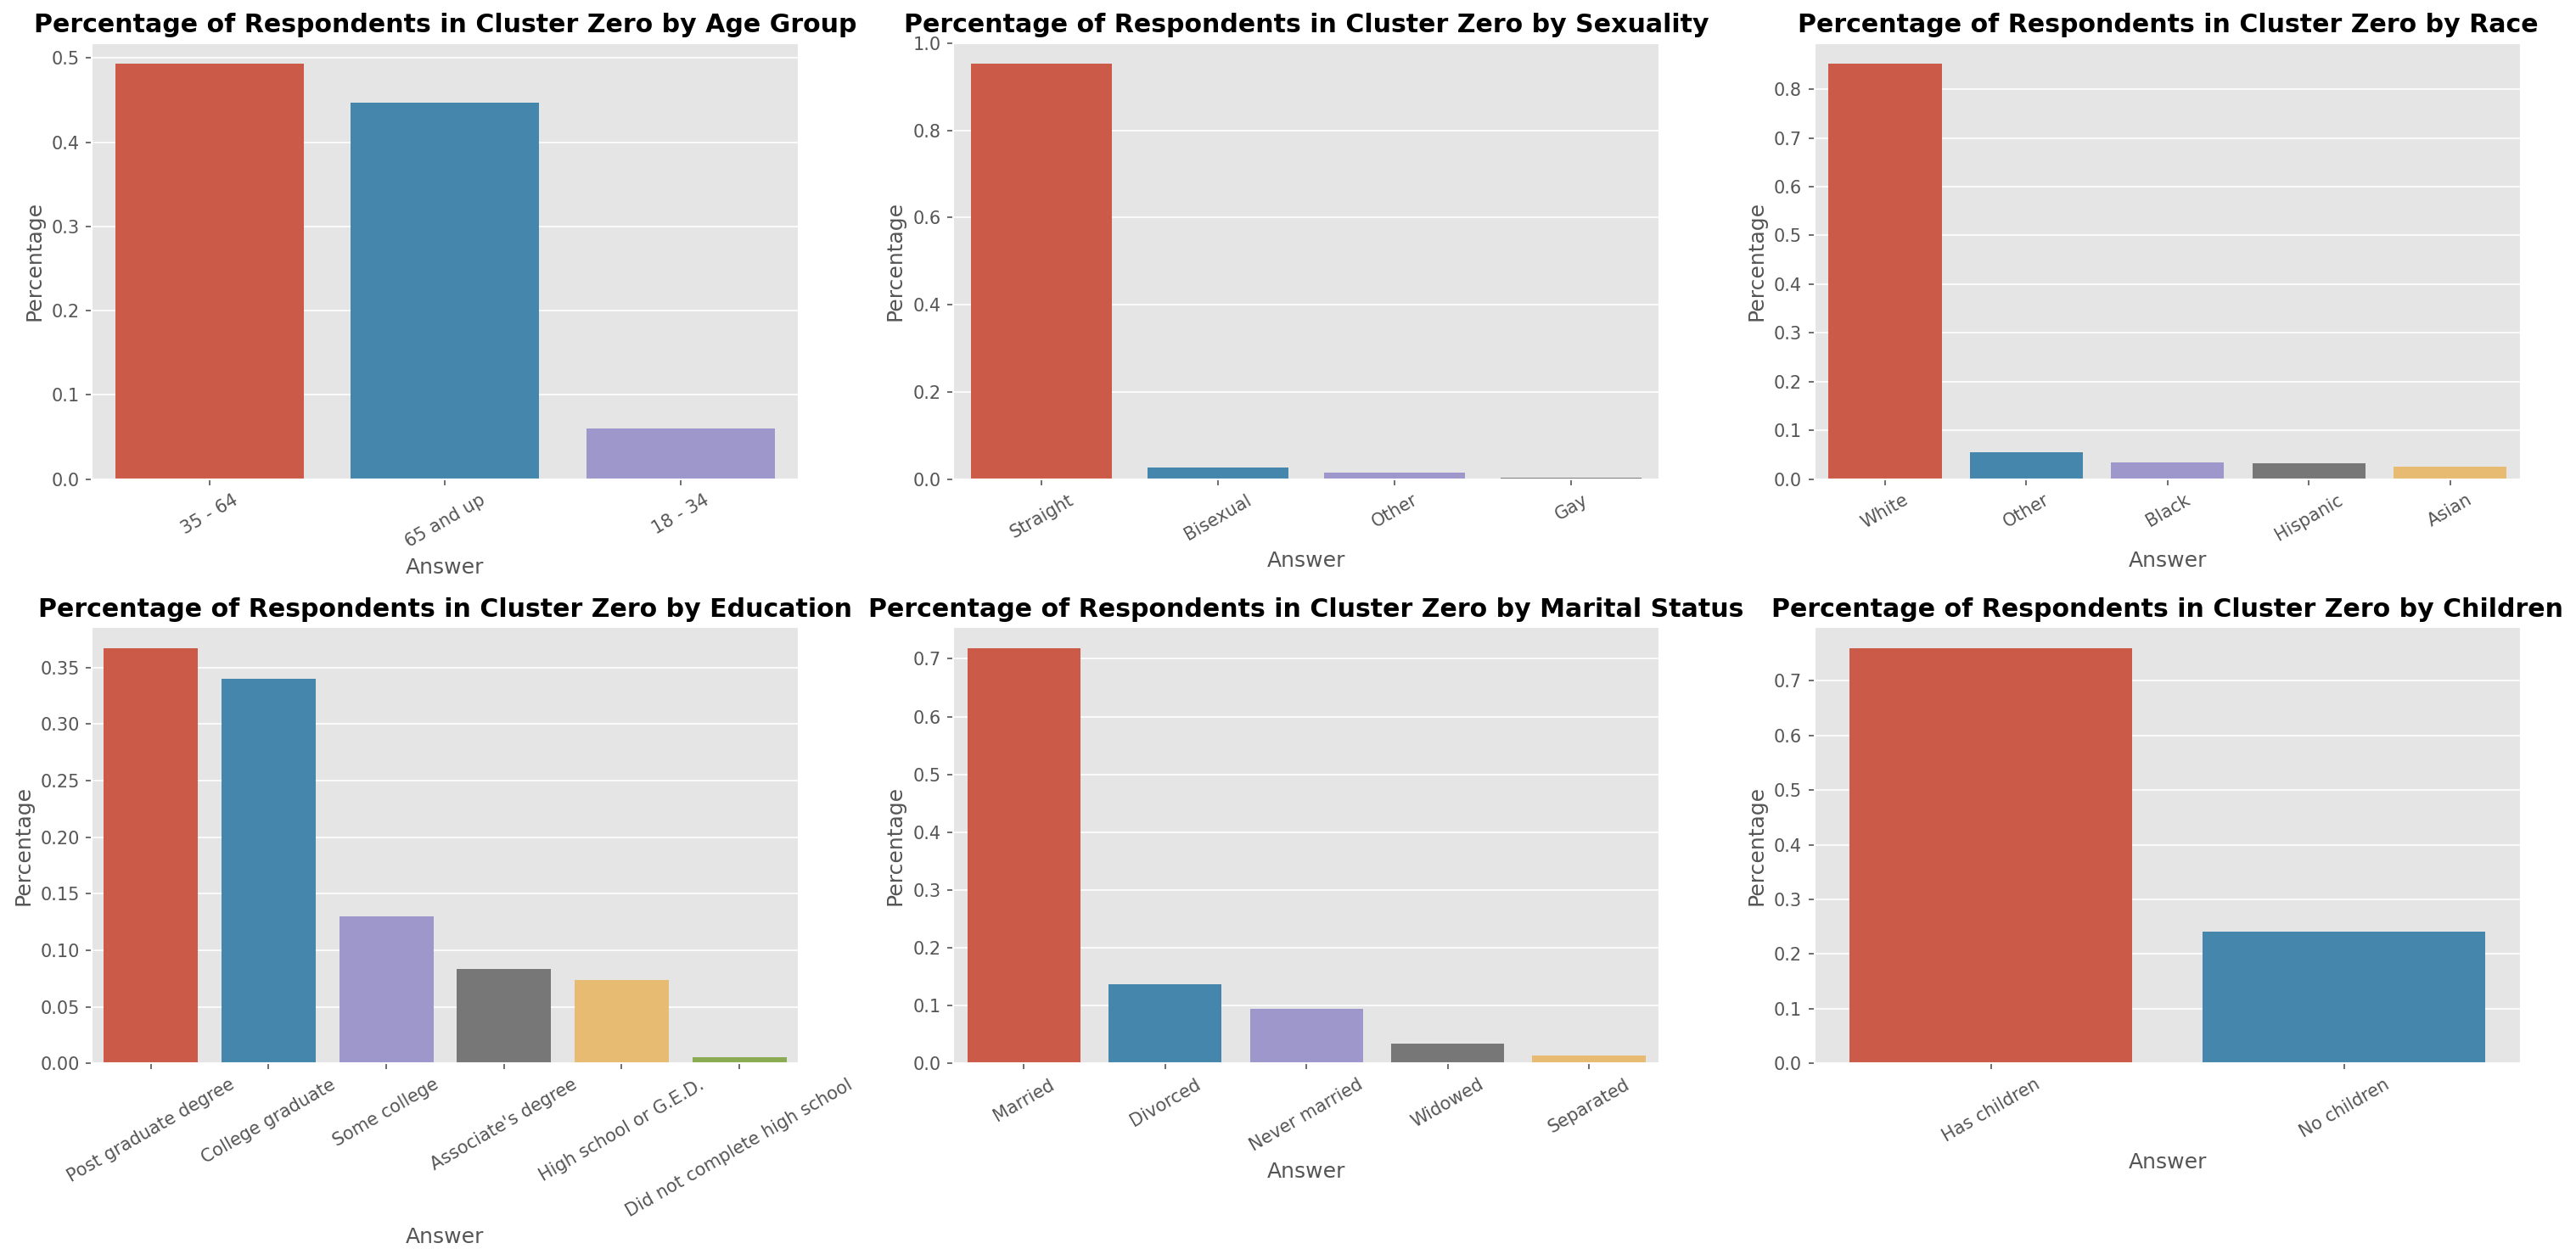

In [71]:
## create demographics dataframes for cluster zero
age_clust_zero = create_dataframe(cluster_zero, 'age3', 'Answer')
sex_clust_zero = create_dataframe(cluster_zero, 'q0026', 'Answer')
race_clust_zero = create_dataframe(cluster_zero, 'q0028', 'Answer')
edu_clust_zero = create_dataframe(cluster_zero, 'q0029', 'Answer')
marriage_clust_zero = create_dataframe(cluster_zero, 'q0024', 'Answer')
child_clust_zero = create_dataframe(cluster_zero, 'kids', 'Answer')

## create a dictionary of dataframes
cluster_zero_dict = {
    'Age Group':age_clust_zero,
    'Sexuality':sex_clust_zero,
    'Race':race_clust_zero,
    'Education':edu_clust_zero,
    'Marital Status':marriage_clust_zero,
    'Children':child_clust_zero
}

## plot 6 charts for cluster zero
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10), dpi=150)
for frame, ax in zip(cluster_zero_dict.keys(), axs.flatten()):
    ax = sns.barplot(x=cluster_zero_dict[frame].columns.tolist()[0], y='Percentage', data=cluster_zero_dict[frame], ax=ax)
    ax.set_xticks(range(len(cluster_zero_dict[frame][cluster_zero_dict[frame].columns.tolist()[0]])))
    ax.set_xticklabels(labels=cluster_zero_dict[frame][cluster_zero_dict[frame].columns.tolist()[0]], rotation=30)
    ax.set_title(f'Percentage of Respondents in Cluster Zero by {frame}', weight='bold')
plt.tight_layout()

##### Cluster One

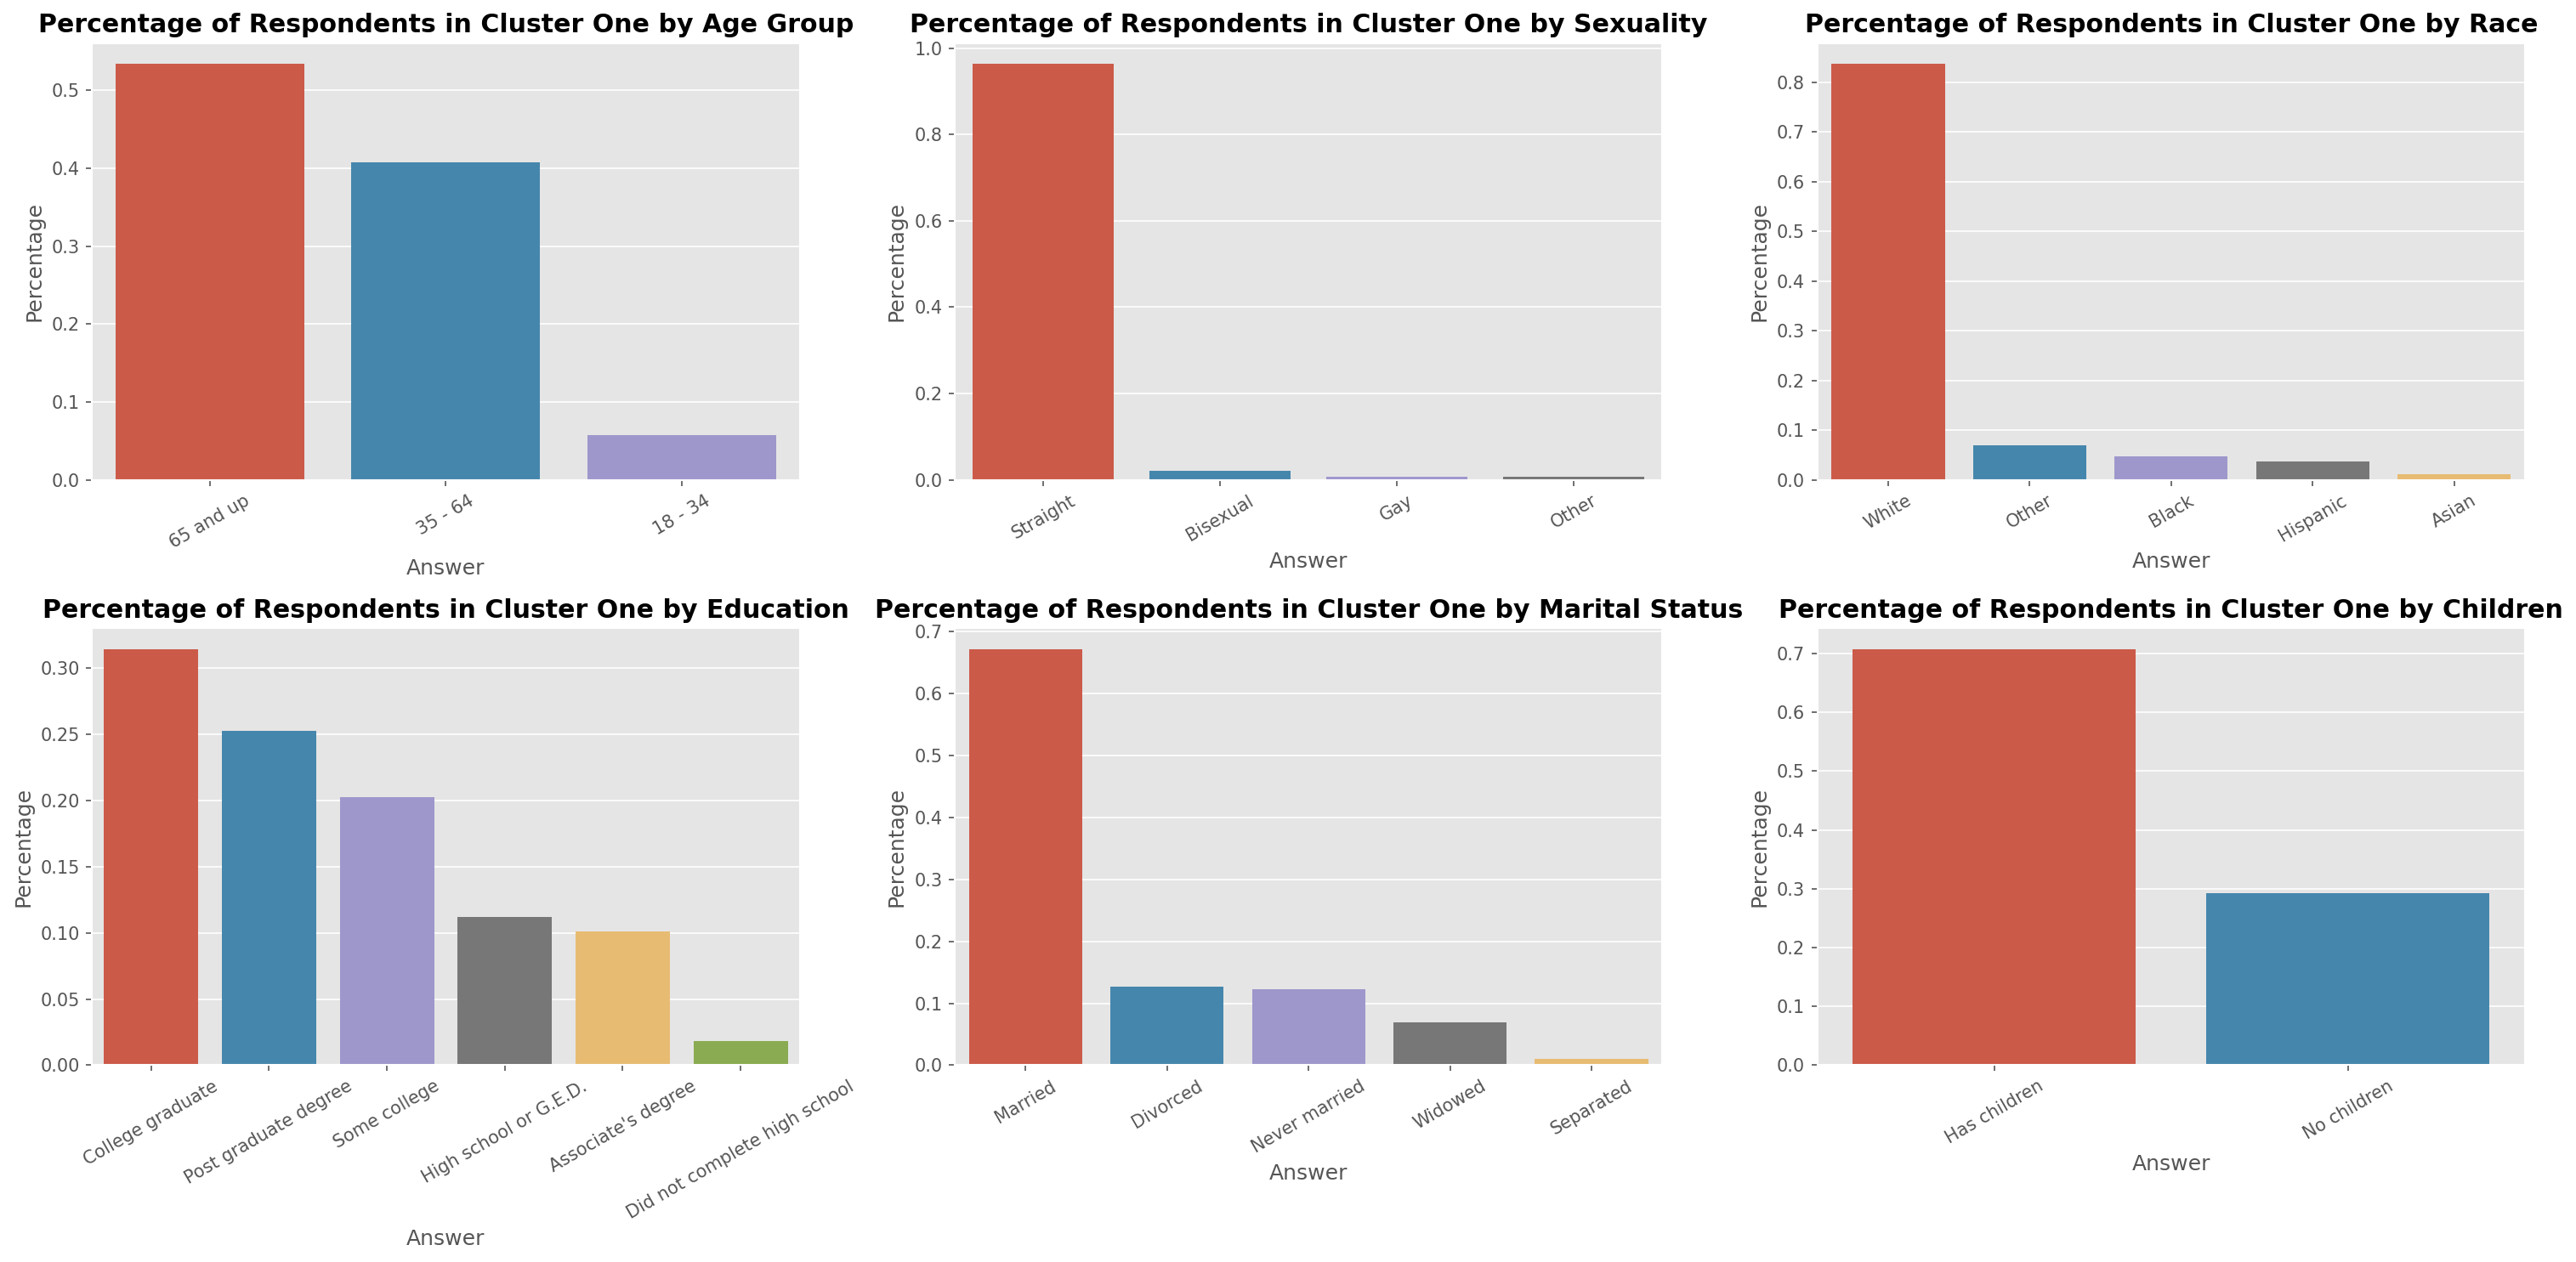

In [72]:
## create demographics dataframes for cluster one
age_clust_one = create_dataframe(cluster_one, 'age3', 'Answer')
sex_clust_one = create_dataframe(cluster_one, 'q0026', 'Answer')
race_clust_one = create_dataframe(cluster_one, 'q0028', 'Answer')
edu_clust_one = create_dataframe(cluster_one, 'q0029', 'Answer')
marriage_clust_one = create_dataframe(cluster_one, 'q0024', 'Answer')
child_clust_one = create_dataframe(cluster_one, 'kids', 'Answer')

## create a dictionary of dataframes
cluster_one_dict = {
    'Age Group':age_clust_one,
    'Sexuality':sex_clust_one,
    'Race':race_clust_one,
    'Education':edu_clust_one,
    'Marital Status':marriage_clust_one,
    'Children':child_clust_one
}

## plot 6 charts for cluster zero
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10), dpi=150)
for frame, ax in zip(cluster_one_dict.keys(), axs.flatten()):
    ax = sns.barplot(x=cluster_one_dict[frame].columns.tolist()[0], y='Percentage', data=cluster_one_dict[frame], ax=ax)
    ax.set_xticks(range(len(cluster_one_dict[frame][cluster_one_dict[frame].columns.tolist()[0]])))
    ax.set_xticklabels(labels=cluster_one_dict[frame][cluster_one_dict[frame].columns.tolist()[0]], rotation=30)
    ax.set_title(f'Percentage of Respondents in Cluster One by {frame}', weight='bold')
plt.tight_layout()

##### Cluster Two

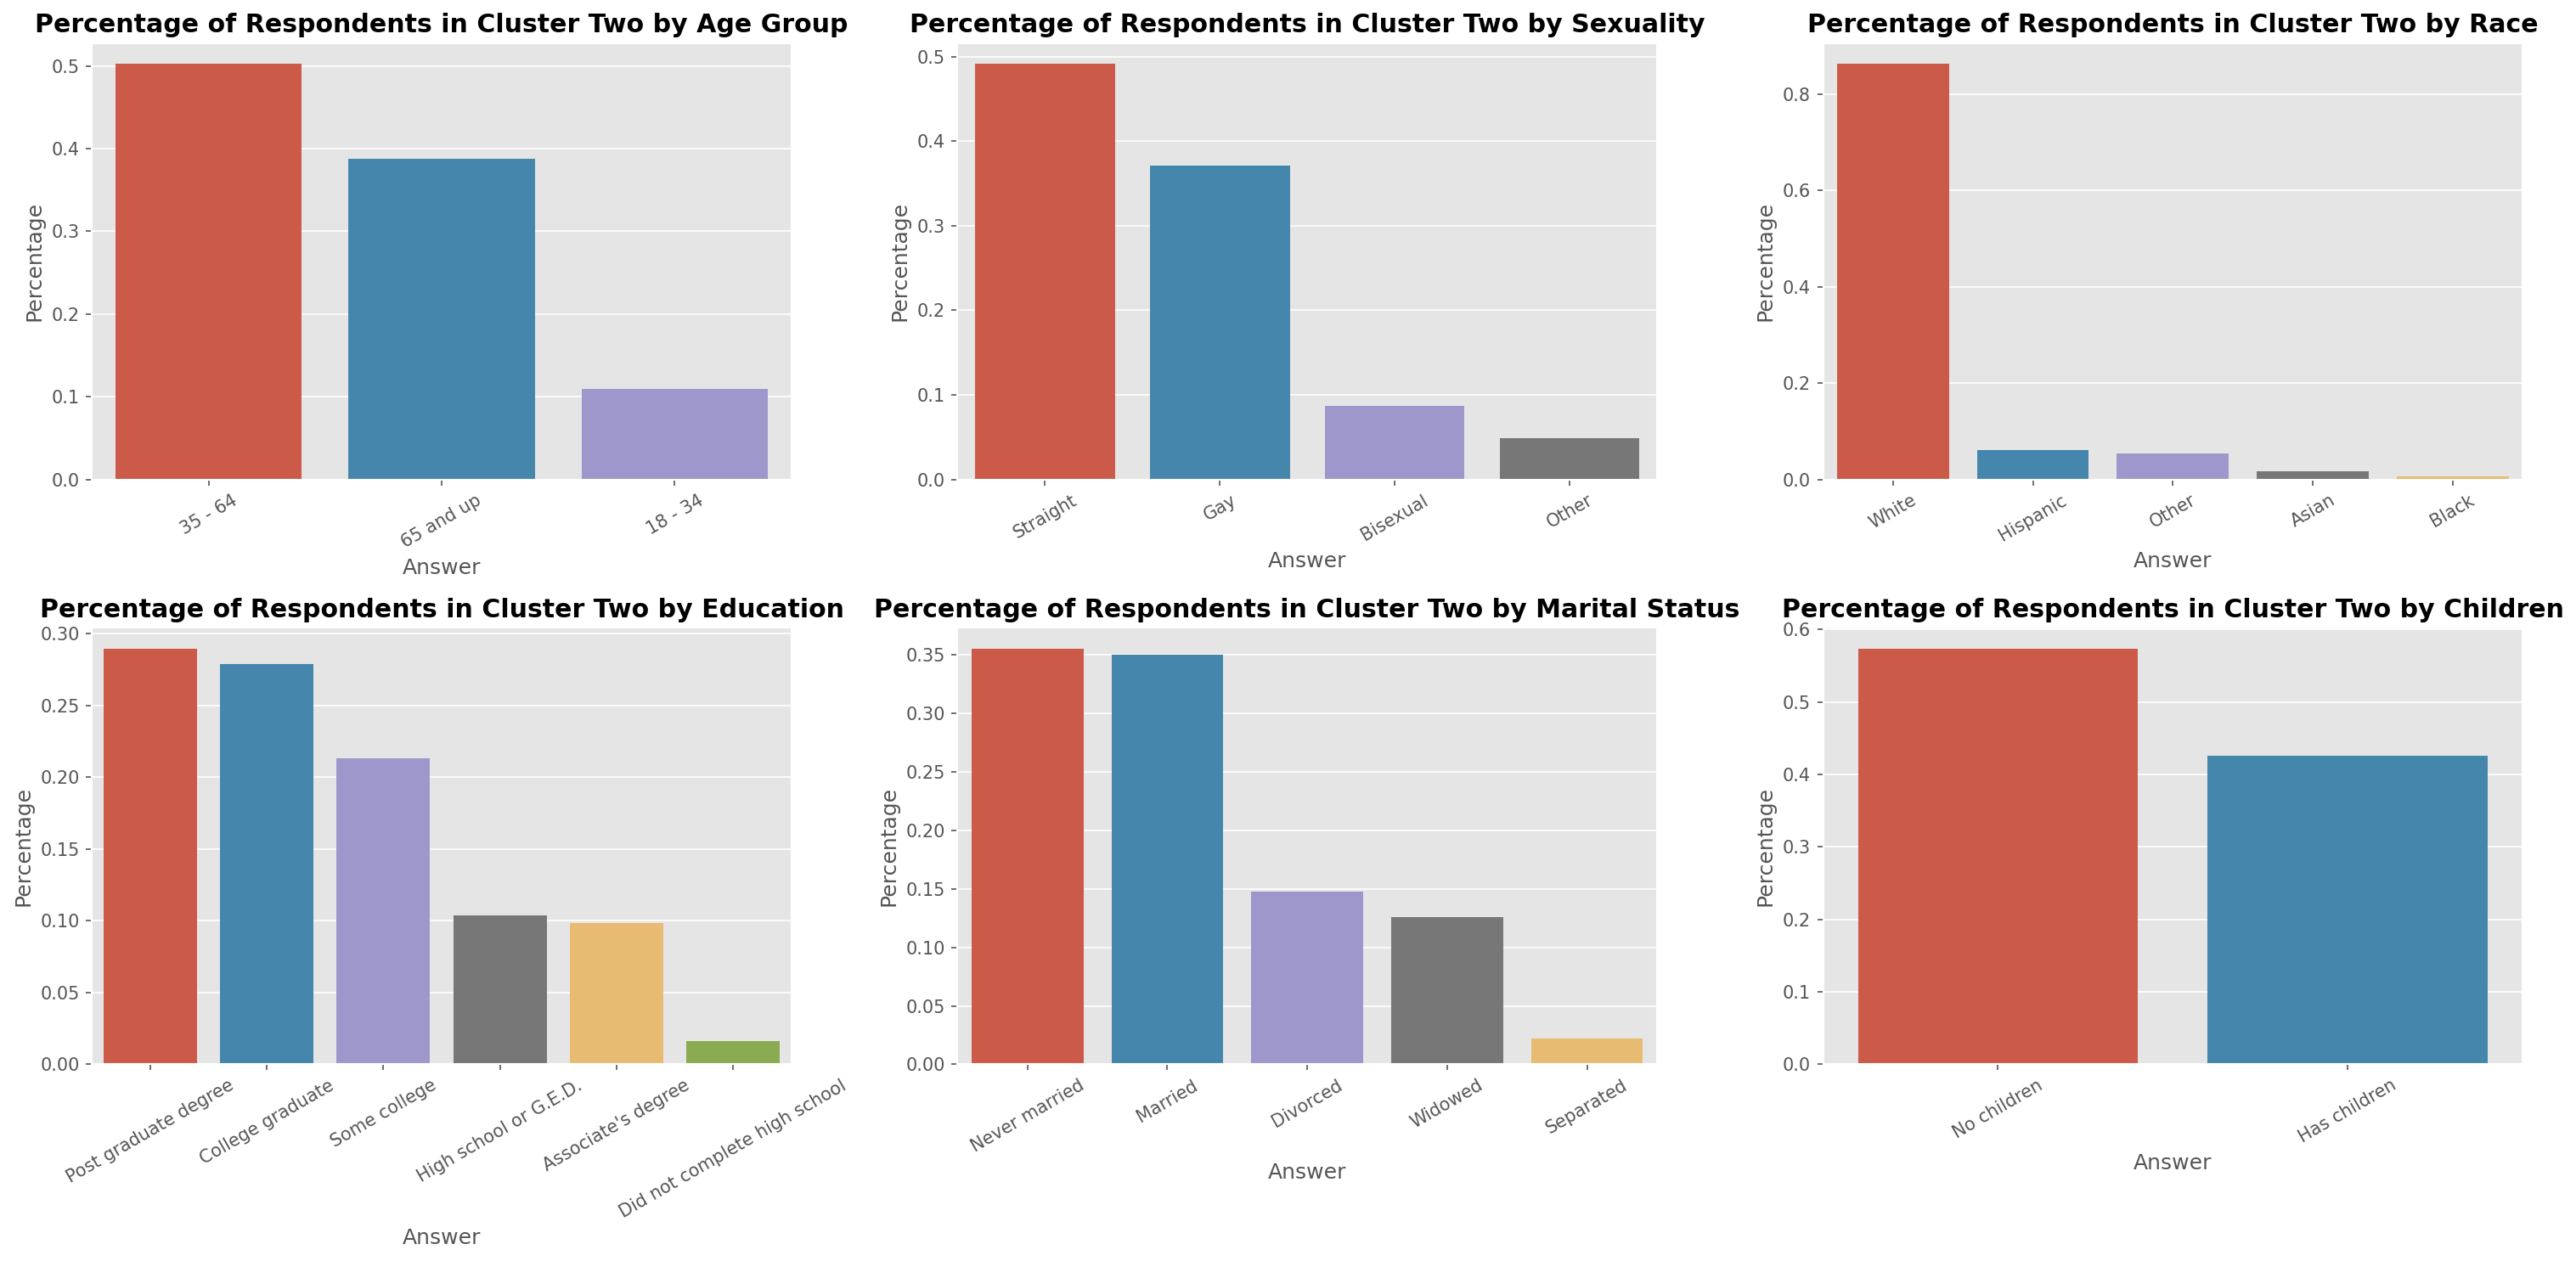

In [73]:
## create demographics dataframes for cluster two
age_clust_two = create_dataframe(cluster_two, 'age3', 'Answer')
sex_clust_two = create_dataframe(cluster_two, 'q0026', 'Answer')
race_clust_two = create_dataframe(cluster_two, 'q0028', 'Answer')
edu_clust_two = create_dataframe(cluster_two, 'q0029', 'Answer')
marriage_clust_two = create_dataframe(cluster_two, 'q0024', 'Answer')
child_clust_two = create_dataframe(cluster_two, 'kids', 'Answer')

## create a dictionary of dataframes
cluster_two_dict = {
    'Age Group':age_clust_two,
    'Sexuality':sex_clust_two,
    'Race':race_clust_two,
    'Education':edu_clust_two,
    'Marital Status':marriage_clust_two,
    'Children':child_clust_two
}

## plot 6 charts for cluster zero
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10), dpi=150)
for frame, ax in zip(cluster_two_dict.keys(), axs.flatten()):
    ax = sns.barplot(x=cluster_two_dict[frame].columns.tolist()[0], y='Percentage', data=cluster_two_dict[frame], ax=ax)
    ax.set_xticks(range(len(cluster_two_dict[frame][cluster_two_dict[frame].columns.tolist()[0]])))
    ax.set_xticklabels(labels=cluster_two_dict[frame][cluster_two_dict[frame].columns.tolist()[0]], rotation=30)
    ax.set_title(f'Percentage of Respondents in Cluster Two by {frame}', weight='bold')
plt.tight_layout()